# Comparisons to the Census Bureau Retail Sales data

And economic models

In [13]:
from datetime import date, datetime
import math

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from scipy.stats import pearsonr, spearmanr

# For Amazon data, make easier to access col names by defining here
RESPONSE_ID = 'Survey ResponseID'
DATE = 'Order Date'
UNIT_PRICE = 'Purchase Price Per Unit'
QUANTITY = 'Quantity'
STATE = 'Shipping Address State'
TITLE = 'Title'
PRODUCT_CODE = 'ASIN/ISBN (Product Code)'
CATEGORY = 'Category'

# Additional / added columns
TOTAL_SPEND = 'spend' # unit price x quantity
WEIGHT = 'Age x Sex weight'
WEIGHTED_SPEND = 'weighted spend' # spend x sample weight
YEAR = 'year'
YYYY_MM = 'yyyy-mm'
# Data collection began 2022-11
MAX_YYYY_MM = '2022-10'

census_data_dir = '../data/census/'

## Amazon data

Load in Amazon data

In [14]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_df = pd.read_csv(amzn_data_fpath, parse_dates=['Order Date'])
# add date columns for analysis convenience
amzn_df[YEAR] = amzn_df[DATE].apply(lambda d: d.year)
amzn_df[YYYY_MM] = amzn_df[DATE].apply(lambda d: date.strftime(d, '%Y-%m'))
# add total spend
amzn_df[TOTAL_SPEND] = amzn_df.apply(lambda row: row[UNIT_PRICE]*row[QUANTITY], axis=1)
# # peek at it:
amzn_df.head(3)

Order Date  Purchase Price Per Unit  Quantity Shipping Address State   
0 2018-12-04                     7.98       1.0                     NJ  \
1 2018-12-22                    13.99       1.0                     NJ   
2 2018-12-24                     8.99       1.0                     NJ   

                                               Title ASIN/ISBN (Product Code)   
0  SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...               B0143RTB1E  \
1  Betron BS10 Earphones Wired Headphones in Ear ...               B01MA1MJ6H   
2                                                NaN               B078JZTFN3   

       Category  Survey ResponseID  year  yyyy-mm  spend  
0  FLASH_MEMORY  R_01vNIayewjIIKMF  2018  2018-12   7.98  
1    HEADPHONES  R_01vNIayewjIIKMF  2018  2018-12  13.99  
2           NaN  R_01vNIayewjIIKMF  2018  2018-12   8.99

### Load in the sample weights to create weighted sample data

In [15]:
sample_weights = pd.read_csv('../data/amazon-data/age-sex-weights.csv').set_index(RESPONSE_ID)
sample_weights.head(3)

Age     Sex               Age x Sex   
Survey ResponseID                                                  
R_1ou69fj4DQGsVcp  35 - 54 years  Female  35 - 54 years x Female  \
R_2UbJL30HRjK1sdD  35 - 54 years    Male    35 - 54 years x Male   
R_UPXamGKtmf4RVIZ  18 - 34 years    Male    18 - 34 years x Male   

                   Age x Sex weight  
Survey ResponseID                    
R_1ou69fj4DQGsVcp          0.796020  
R_2UbJL30HRjK1sdD          0.881081  
R_UPXamGKtmf4RVIZ          0.630252

In [16]:
amzn_df[WEIGHT] = amzn_df[RESPONSE_ID].map(sample_weights[WEIGHT]).fillna(0)
amzn_df[WEIGHTED_SPEND] = amzn_df[WEIGHT]*amzn_df[TOTAL_SPEND]
amzn_df.head(3)

Order Date  Purchase Price Per Unit  Quantity Shipping Address State   
0 2018-12-04                     7.98       1.0                     NJ  \
1 2018-12-22                    13.99       1.0                     NJ   
2 2018-12-24                     8.99       1.0                     NJ   

                                               Title ASIN/ISBN (Product Code)   
0  SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...               B0143RTB1E  \
1  Betron BS10 Earphones Wired Headphones in Ear ...               B01MA1MJ6H   
2                                                NaN               B078JZTFN3   

       Category  Survey ResponseID  year  yyyy-mm  spend  Age x Sex weight   
0  FLASH_MEMORY  R_01vNIayewjIIKMF  2018  2018-12   7.98          0.881081  \
1    HEADPHONES  R_01vNIayewjIIKMF  2018  2018-12  13.99          0.881081   
2           NaN  R_01vNIayewjIIKMF  2018  2018-12   8.99          0.881081   

   weighted spend  
0        7.031027  
1       12.326324  
2        7.920919

In [17]:
def print_data_metrics(data_df):
    print('%s purchases' % len(data_df))
    print('%s response Ids' % data_df[RESPONSE_ID].nunique())

print_data_metrics(amzn_df)

1850717 purchases
5027 response Ids


In [18]:
# limit to purchases before 2022-11
print('Limiting amazon data to purchases up to date %s:' % MAX_YYYY_MM)
amzn_df = amzn_df[amzn_df[YYYY_MM] <= MAX_YYYY_MM]
print_data_metrics(amzn_df)

Limiting amazon data to purchases up to date 2022-10:
1737058 purchases
5015 response Ids


In [19]:
# index for plotting
yyyy_mm_idx = sorted(amzn_df[YYYY_MM].unique())

### Amazon prime day

Get the dates for Amazon prime day, as this impact purchases

In [20]:
amzn_prime_ds = [
    '2018-07-16',
    '2019-07-15',
    '2020-10-13',
    '2021-06-21',
    '2022-07-13',
]
amzn_prime_dates = [datetime.strptime(d, '%Y-%m-%d') for d in amzn_prime_ds]
amzn_prime_ms = [
    '2018-07',
    '2019-07',
    '2020-10',
    '2021-06',
    '2022-07',
]

## US Census Bureau Retail Sales data


Information about the Monthly Retail Trade Survey can be found on the Census website at https://www.census.gov/retail/mrts/about_the_surveys.html

We use Not Seasonally Adjusted data
Data are downloaded for January 2018 to October 2022 to spreadsheets: [drive link](https://docs.google.com/spreadsheets/d/1fYT2jK75SeJM_xEys765nqnnV5xvkN2SC0wpvNgH-IE/)

Retail Sales: Supermarkets and Other Grocery (Except Convenience) Stores 
https://fred.stlouisfed.org/series/MRTSSM44511USN 

Retail Sales: Book Stores
https://fred.stlouisfed.org/series/MRTSSM451211USN 

Retail Sales: Shoe Stores
https://fred.stlouisfed.org/series/MRTSSM4482USN

Retail Sales: Pharmacies and Drug Stores
https://fred.stlouisfed.org/series/MRTSSM44611USN 



In [21]:
# sales are in millions of dollars
retail_sales = pd.read_csv(census_data_dir+'retail-sales.csv', parse_dates=['Date']).set_index('Date')
retail_sales.head()

Grocery  Book stores  Shoe stores  Pharmacy
Date                                                   
2018-01-01    52565         1207         2058     23549
2018-02-01    48628          634         2672     21336
2018-03-01    54680          652         3243     23348
2018-04-01    50861          624         2890     22506
2018-05-01    55043          691         3112     24074

In [22]:
book_cats = ['ABIS_BOOK', 'BOOK', 'BOOKS_1973_AND_LATER']
shoes_cats = ['SHOES', 'TECHNICAL_SPORT_SHOE', 'BOOT', 'SANDAL', 'SLIPPER']

In [52]:
book_purchases = amzn_df[amzn_df['Category'].isin(book_cats)]
print('%s book purchases from N=%s users' % (len(book_purchases), book_purchases[RESPONSE_ID].nunique()))
book_purchases_m = book_purchases.groupby(YYYY_MM)[TOTAL_SPEND].sum()
w_book_purchases_m = book_purchases.groupby(YYYY_MM)[WEIGHTED_SPEND].sum()
print('Comparing retail sales to Amazon sample spend')
print('Pearson r=%0.3f p-value=%0.3f' % pearsonr(book_purchases_m, retail_sales['Book stores']))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(book_purchases_m, retail_sales['Book stores']))
print('Comparing retail sales to weighted Amazon sample spend')
print('Pearson r=%0.3f; p-value=%0.3f' % pearsonr(w_book_purchases_m, retail_sales['Book stores']))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(w_book_purchases_m, retail_sales['Book stores']))

83140 book purchases from N=4188 users
Comparing retail sales to Amazon sample spend
Pearson r=0.631 p-value=0.000
Spearman r=0.365; p-value=0.005
Comparing retail sales to weighted Amazon sample spend
Pearson r=0.575; p-value=0.000
Spearman r=0.370; p-value=0.004


In [53]:
shoes_purchases = amzn_df[amzn_df['Category'].isin(shoes_cats)]
print('%s shoes purchases from N=%s users' % (len(shoes_purchases), shoes_purchases[RESPONSE_ID].nunique()))
shoes_purchases_m = shoes_purchases.groupby(YYYY_MM)[TOTAL_SPEND].sum()
w_shoes_purchases_m = shoes_purchases.groupby(YYYY_MM)[WEIGHTED_SPEND].sum()
print('Comparing retail sales to Amazon sample spend')
print('Pearson r=%0.3f; p-value=%0.3f' % pearsonr(shoes_purchases_m, retail_sales['Shoe stores']))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(shoes_purchases_m, retail_sales['Shoe stores']))
print('Comparing retail sales to weighted Amazon sample spend')
print('Pearson r=%0.3f; p-value=%0.3f' % pearsonr(w_shoes_purchases_m, retail_sales['Shoe stores']))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(w_shoes_purchases_m, retail_sales['Shoe stores']))

20885 shoes purchases from N=3344 users
Comparing retail sales to Amazon sample spend
Pearson r=0.447; p-value=0.000
Spearman r=0.484; p-value=0.000
Comparing retail sales to weighted Amazon sample spend
Pearson r=0.485; p-value=0.000
Spearman r=0.495; p-value=0.000


In [54]:
grocery_cats = [
    'GROCERY', 'FOOD', 'VEGETABLE', 'FRUIT', 'DAIRY_BASED_CHEESE', 'BREAD', 'POULTRY', 
    'DRINK_FLAVORED', 'SNACK_CHIP_AND_CRISP', 
    'HERB', 'MEAT', 'FRUIT_SNACK', 'SAUCE', 'NUT_AND_SEED', 'SNACK_MIX', 'WATER', 
    'DAIRY_BASED_CREAM', 'NOODLE', 'PUFFED_SNACK', 'PACKAGED_SOUP_AND_STEW', 
    'MILK_SUBSTITUTE', 'CRACKER', 'COOKIE', 'SUGAR_CANDY', 'SYRUP', 'DAIRY_BASED_BUTTER', 
    'BREAKFAST_CEREAL', 'COFFEE', 'TEA', 'SNACK_FOOD_BAR', 'POPCORN', 'LEAVENING_AGENT', 
    'Grocery', 'DAIRY_BASED_YOGURT', 'CHOCOLATE_CANDY', 'EDIBLE_OIL_VEGETABLE', 
    'JUICE_AND_JUICE_DRINK', 'SEASONING', 'CAKE', 'DAIRY_BASED_ICE_CREAM', 
    'DAIRY_BASED_DRINK', 'CONDIMENT', 'LEGUME', 'RICE_MIX', 
    'CHEWING_GUM', 'FISH', 'CULINARY_SALT', 'SUGAR', 'NUTRITIONAL_SUPPLEMENT', 
    'NUT_BUTTER', 'PASTRY', 'THICKENING_AGENT', 'CEREAL', 'BAKING_MIX', 'SALAD_DRESSING', 
    'HERBAL_SUPPLEMENT'
]

In [56]:
groc_purchases = amzn_df[amzn_df['Category'].isin(grocery_cats)]
print('%s grocery purchases from N=%s users' % (len(groc_purchases), groc_purchases[RESPONSE_ID].nunique()))
groc_purchases_m = groc_purchases.groupby(YYYY_MM)[TOTAL_SPEND].sum()
w_groc_purchases_m = groc_purchases.groupby(YYYY_MM)[WEIGHTED_SPEND].sum()

print('Comparing retail sales to Amazon sample spend')
print('Pearson r=%0.3f; p-value=%0.3f' % pearsonr(groc_purchases_m, retail_sales['Grocery']))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(groc_purchases_m, retail_sales['Grocery']))
print('Comparing retail sales to weighted Amazon sample spend')
print('Pearson r=%0.3f; p-value=%0.3f' % pearsonr(w_groc_purchases_m, retail_sales['Grocery']))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(w_groc_purchases_m, retail_sales['Grocery']))

219749 grocery purchases from N=4185 users
Comparing retail sales to Amazon sample spend
Pearson r=0.874; p-value=0.000
Spearman r=0.867; p-value=0.000
Comparing retail sales to weighted Amazon sample spend
Pearson r=0.881; p-value=0.000
Spearman r=0.864; p-value=0.000


In [57]:
# found by looking at the categories with highest value counts
pharmacy_cats = [
    'HEALTH_PERSONAL_CARE',
    'MEDICATION',
    # include these? yes: better Pearson correlation
    'VITAMIN',
    'HERBAL_SUPPLEMENT',
]
pharmacy_plus_cats = pharmacy_cats + [
    'SKIN_MOISTURIZER',
    'SKIN_CLEANING_AGENT',
    'BEAUTY',
    #'SAFETY_MASK', # face masks -- lowers Pearson correlation
]

In [58]:
pharm_purchases = amzn_df[amzn_df['Category'].isin(pharmacy_cats)]
print('%s pharmacy related purchases from N=%s users' % (len(pharm_purchases), pharm_purchases[RESPONSE_ID].nunique()))
pharm_purchases_m = pharm_purchases.groupby(YYYY_MM)[TOTAL_SPEND].sum()

pharm_plus_purchases = amzn_df[amzn_df['Category'].isin(pharmacy_plus_cats)]
print('%s pharmacy+ related purchases from N=%s users' % (len(pharm_plus_purchases), pharm_plus_purchases[RESPONSE_ID].nunique()))
pharm_plus_purchases_m = pharm_plus_purchases.groupby(YYYY_MM)[TOTAL_SPEND].sum()

49184 pharmacy related purchases from N=3750 users
81134 pharmacy+ related purchases from N=4190 users


In [59]:
print('Pharmacy related purchases compared to Census pharmacy retail sales data')
print(pharmacy_cats)
r, pval = pearsonr(pharm_purchases_m, retail_sales['Pharmacy'])
print('Pearson r=%0.3f; p-value=%0.3f' % (r, pval))
print('\nPharmacy+ related purchases compared to Census pharmacy retail sales data')
print(pharmacy_plus_cats)
r, pval = pearsonr(pharm_plus_purchases_m, retail_sales['Pharmacy'])
print('Pearson r=%0.3f; p-value=%0.3f' % (r, pval))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(pharm_plus_purchases_m, retail_sales['Pharmacy']))

Pharmacy related purchases compared to Census pharmacy retail sales data
['HEALTH_PERSONAL_CARE', 'MEDICATION', 'VITAMIN', 'HERBAL_SUPPLEMENT']
Pearson r=0.819; p-value=0.000

Pharmacy+ related purchases compared to Census pharmacy retail sales data
['HEALTH_PERSONAL_CARE', 'MEDICATION', 'VITAMIN', 'HERBAL_SUPPLEMENT', 'SKIN_MOISTURIZER', 'SKIN_CLEANING_AGENT', 'BEAUTY']
Pearson r=0.826; p-value=0.000
Spearman r=0.842; p-value=0.000


The unweighted data is more correlated with retail sales data.

In [85]:
w_pharm_purchases_m = pharm_purchases.groupby(YYYY_MM)[WEIGHTED_SPEND].sum()
w_pharm_plus_purchases_m = pharm_plus_purchases.groupby(YYYY_MM)[WEIGHTED_SPEND].sum()
print('Weighted Pharmacy related purchases compared to Census pharmacy retail sales data')
r, pval = pearsonr(w_pharm_purchases_m, retail_sales['Pharmacy'])
print('Pearson r=%0.3f; p-value=%0.3f' % (r, pval))
print('Weighted Pharmacy+ related purchases compared to Census pharmacy retail sales data')
r, pval = pearsonr(w_pharm_plus_purchases_m, retail_sales['Pharmacy'])
print('Pearson r=%0.3f; p-value=%0.3f' % (r, pval))
print('Spearman r=%0.3f; p-value=%0.3f' % spearmanr(w_pharm_plus_purchases_m, retail_sales['Pharmacy']))

Weighted Pharmacy related purchases compared to Census pharmacy retail sales data
Pearson r=0.811; p-value=0.000
Weighted Pharmacy+ related purchases compared to Census pharmacy retail sales data
Pearson r=0.814; p-value=0.000
Spearman r=0.830; p-value=0.000


In [86]:
retail_sales.reindex(yyyy_mm_idx).head(3)

Grocery  Book stores  Shoe stores  Pharmacy
Date                                                
2018-01    52565         1207         2058     23549
2018-02    48628          634         2672     21336
2018-03    54680          652         3243     23348

## Plots to compare Amazon purchases and Census Retail Sales

In [198]:
amzn_prime_color = 'blue' 
covid_color = 'orange'
amzn_sample_spend_color = 'black'
census_color = 'black' #'red'
census_linestyle = (0, (1,1)) # densely dotted
# census_linestyle = (0, (5,1)) # densely dashed

In [199]:
def plot_monthly_data(series, ax=None, xmin='2018-01', xmax=MAX_YYYY_MM, ylabel=None,
                      label=None, title=None, show_covid=False, show_prime_dates=False,
                      color=None, linestyle=None, legend=True, rotate_xticks=True):
    if ax is None:
        _fig, ax = plt.subplots(1,1, figsize=(14,2))
    ax.plot(series, label=label, color=color, linestyle=(linestyle or '-'))
    ax.set_xlim(xmin, xmax)
    if show_covid: ax.axvline(x='2020-03', ymin=0, color=covid_color, linestyle='-')
    if show_prime_dates: [ax.axvline(x=m, ymin=0, color=amzn_prime_color, alpha=0.2) for m in amzn_prime_ms]
    if title: ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    if label and legend: ax.legend(loc='upper left')
    if rotate_xticks: plt.xticks(rotation=90)
    return ax

Books and groceries: Retail vs Amazon sample spend


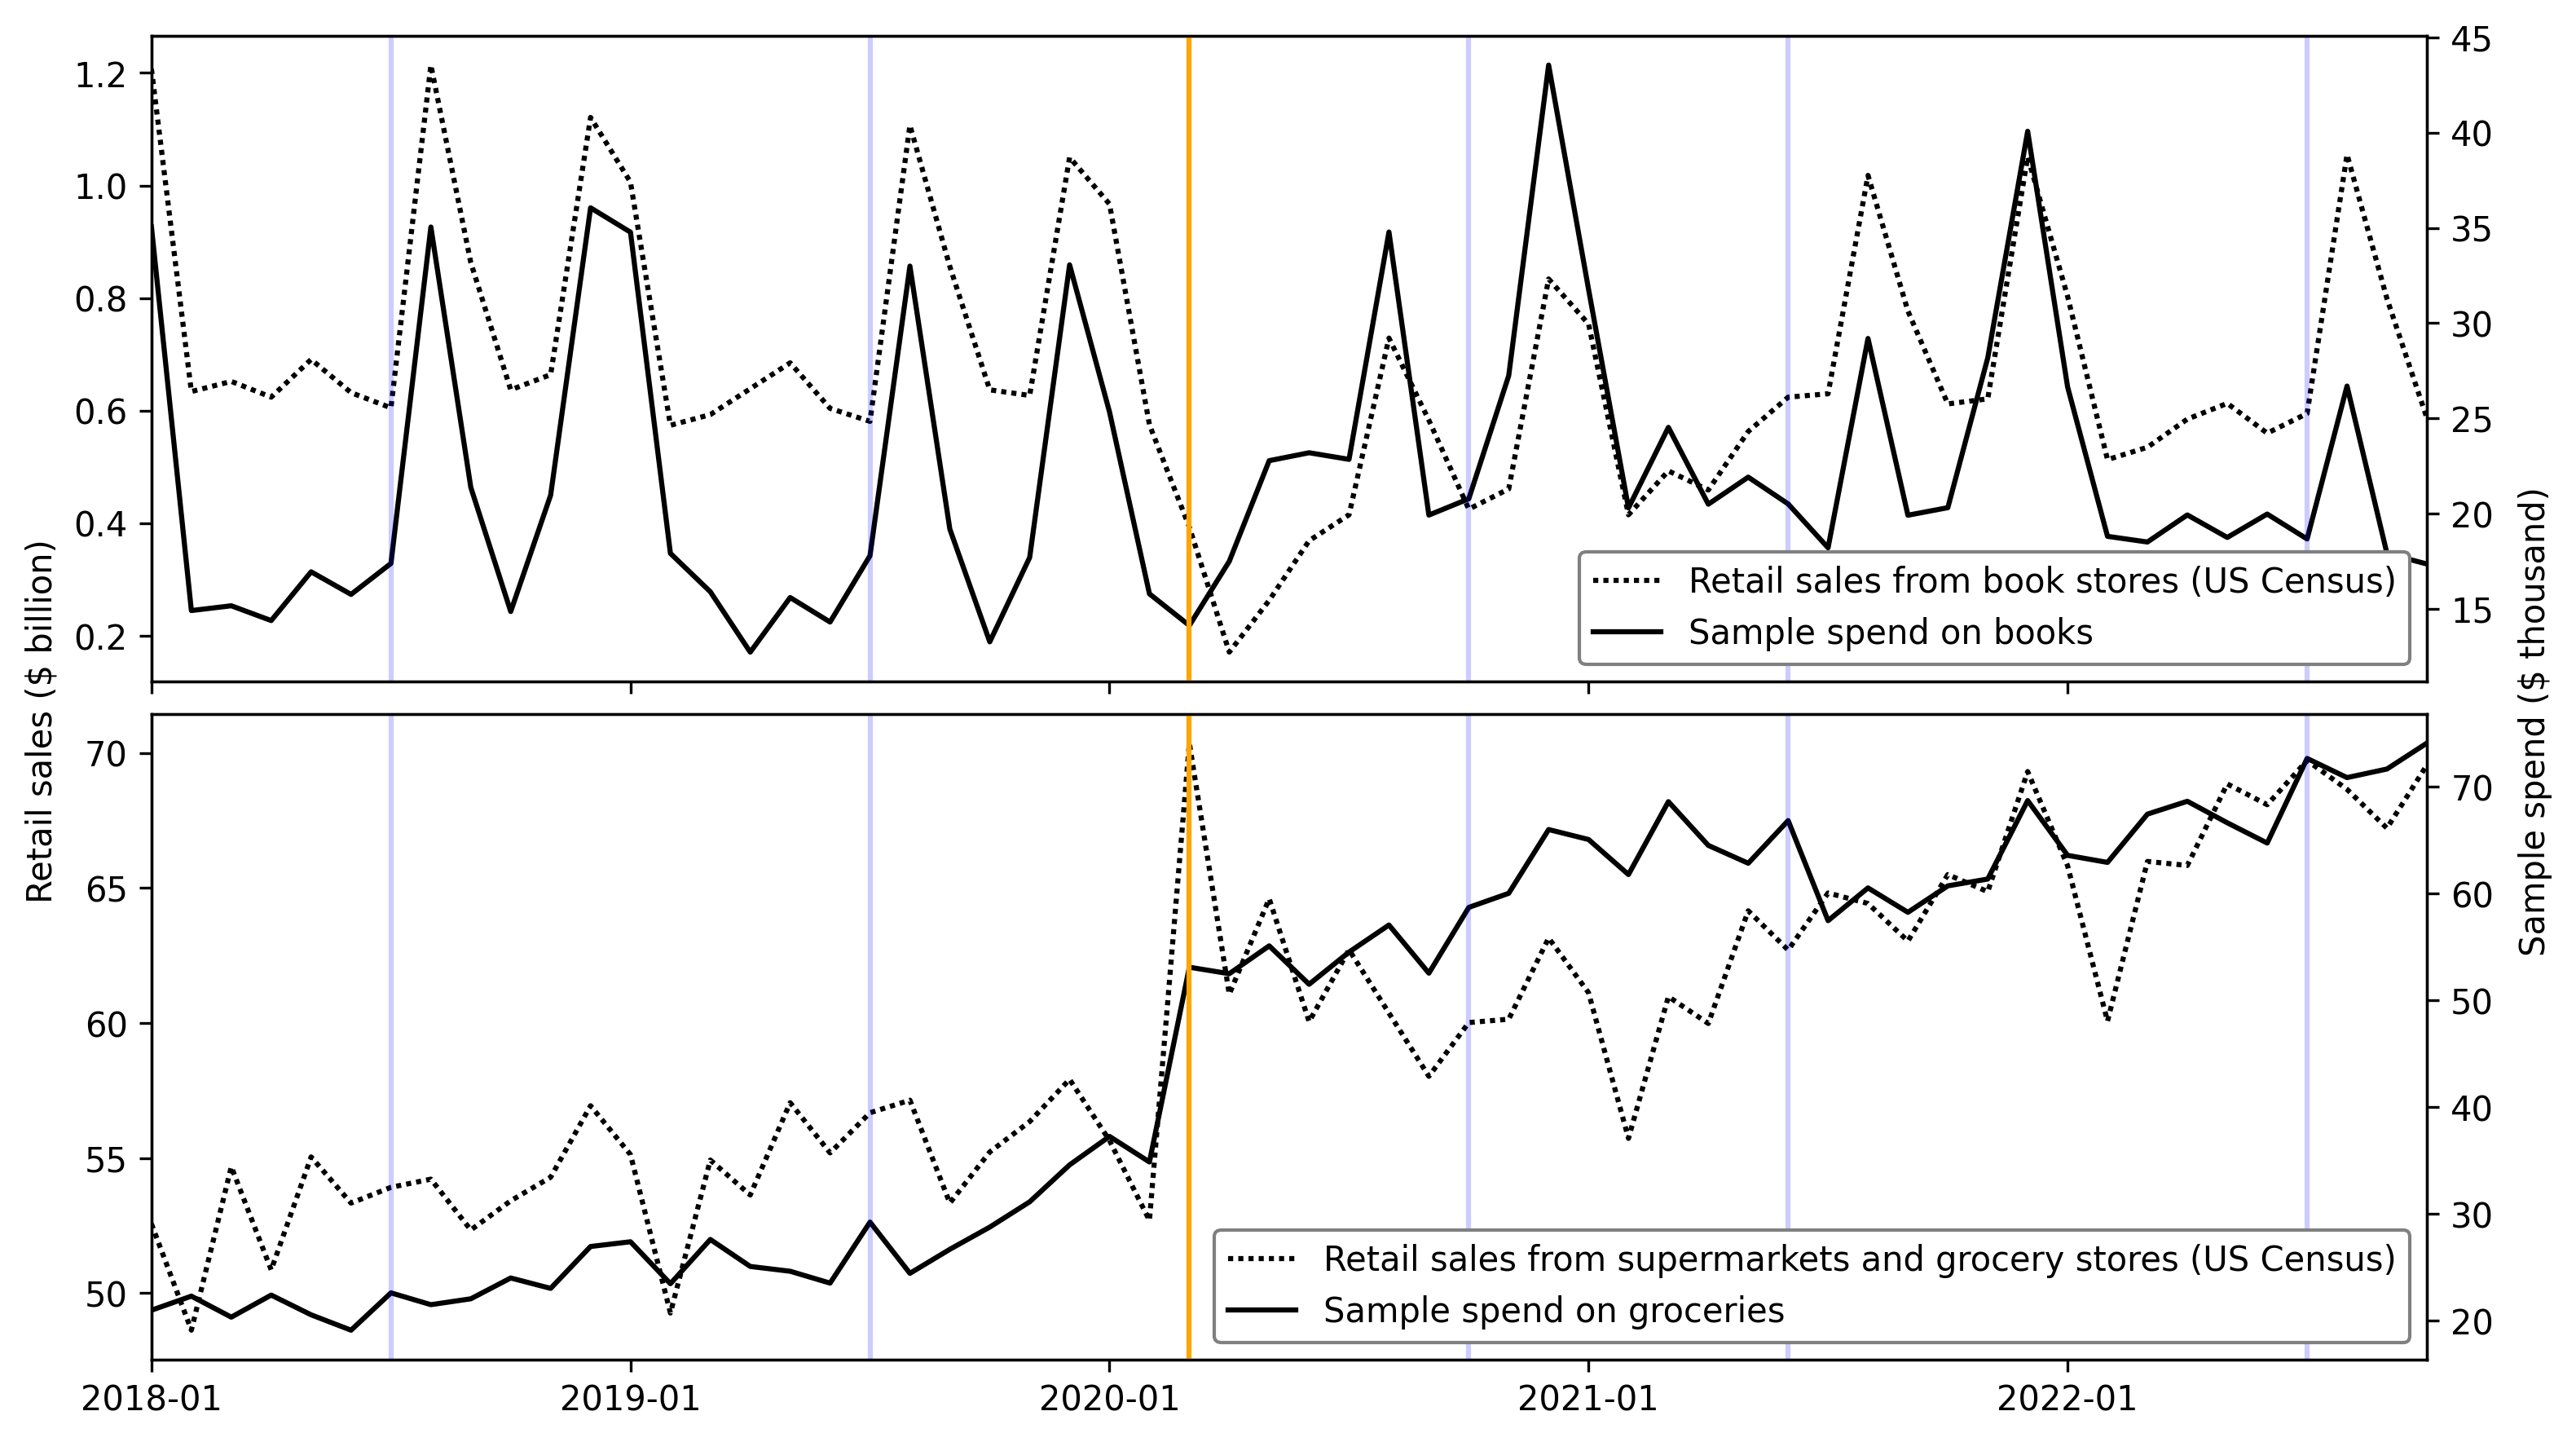

In [200]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10.2,6), sharex=True, dpi=300)
print('Books and groceries: Retail vs Amazon sample spend')
plot_monthly_data(
    retail_sales.reindex(yyyy_mm_idx)['Book stores']/1000, ax=ax0,
    label='Retail sales from book stores (US Census)', color='black', linestyle=census_linestyle,
    legend=False,
    rotate_xticks=False
)
ax0r = ax0.twinx()
plot_monthly_data(
    book_purchases_m/1000, ax=ax0r, label='Sample spend on books', legend=False, 
    color=amzn_sample_spend_color, show_covid=True, show_prime_dates=True,
    rotate_xticks=False,
)
ax0.set_xticks(['2018-01','2019-01','2020-01','2021-01','2022-01'])
_ = plt.legend(
    handles=[ax0.get_lines()[0], ax0r.get_lines()[0]], 
    edgecolor='gray', facecolor='white', framealpha=1,
    loc='lower right'
)
plt.xticks(rotation=0)
plt.tight_layout()
plot_monthly_data(
    retail_sales.reindex(yyyy_mm_idx)['Grocery']/1000, ax=ax1,
    label='Retail sales from supermarkets and grocery stores (US Census)', 
    color='black', linestyle=census_linestyle, legend=False, 
    rotate_xticks=False,
)
ax1r = ax1.twinx()
plot_monthly_data(
    groc_purchases_m/1000, ax=ax1r, label='Sample spend on groceries', 
    color=amzn_sample_spend_color, legend=False, show_covid=True, show_prime_dates=True,
    rotate_xticks=False,
)
_ = plt.legend(
    handles=[ax1.get_lines()[0], ax1r.get_lines()[0]], 
    edgecolor='gray', facecolor='white', framealpha=1,
    loc='lower right'
)
fig.subplots_adjust(hspace=0.05)
_ = fig.text(-0.005, 0.5, 'Retail sales ($ billion)', va='center', rotation=90, fontsize='medium')
_ = fig.text(0.995, 0.5, 'Sample spend ($ thousand)', va='center', rotation=90, fontsize='medium')

In [213]:
plt_text_list = [
    ('Book stores', 'book stores', 'books', book_purchases_m),
    ('Shoe stores', 'shoe stores', 'shoes', shoes_purchases_m),
    ('Grocery', 'supermarkets and grocery stores', 'groceries', groc_purchases_m),
    ('Pharmacy', 'pharmacies and drugs stores', 'pharmacy related products', pharm_plus_purchases_m),
]

Retail sales for book stores vs Amazon books sales


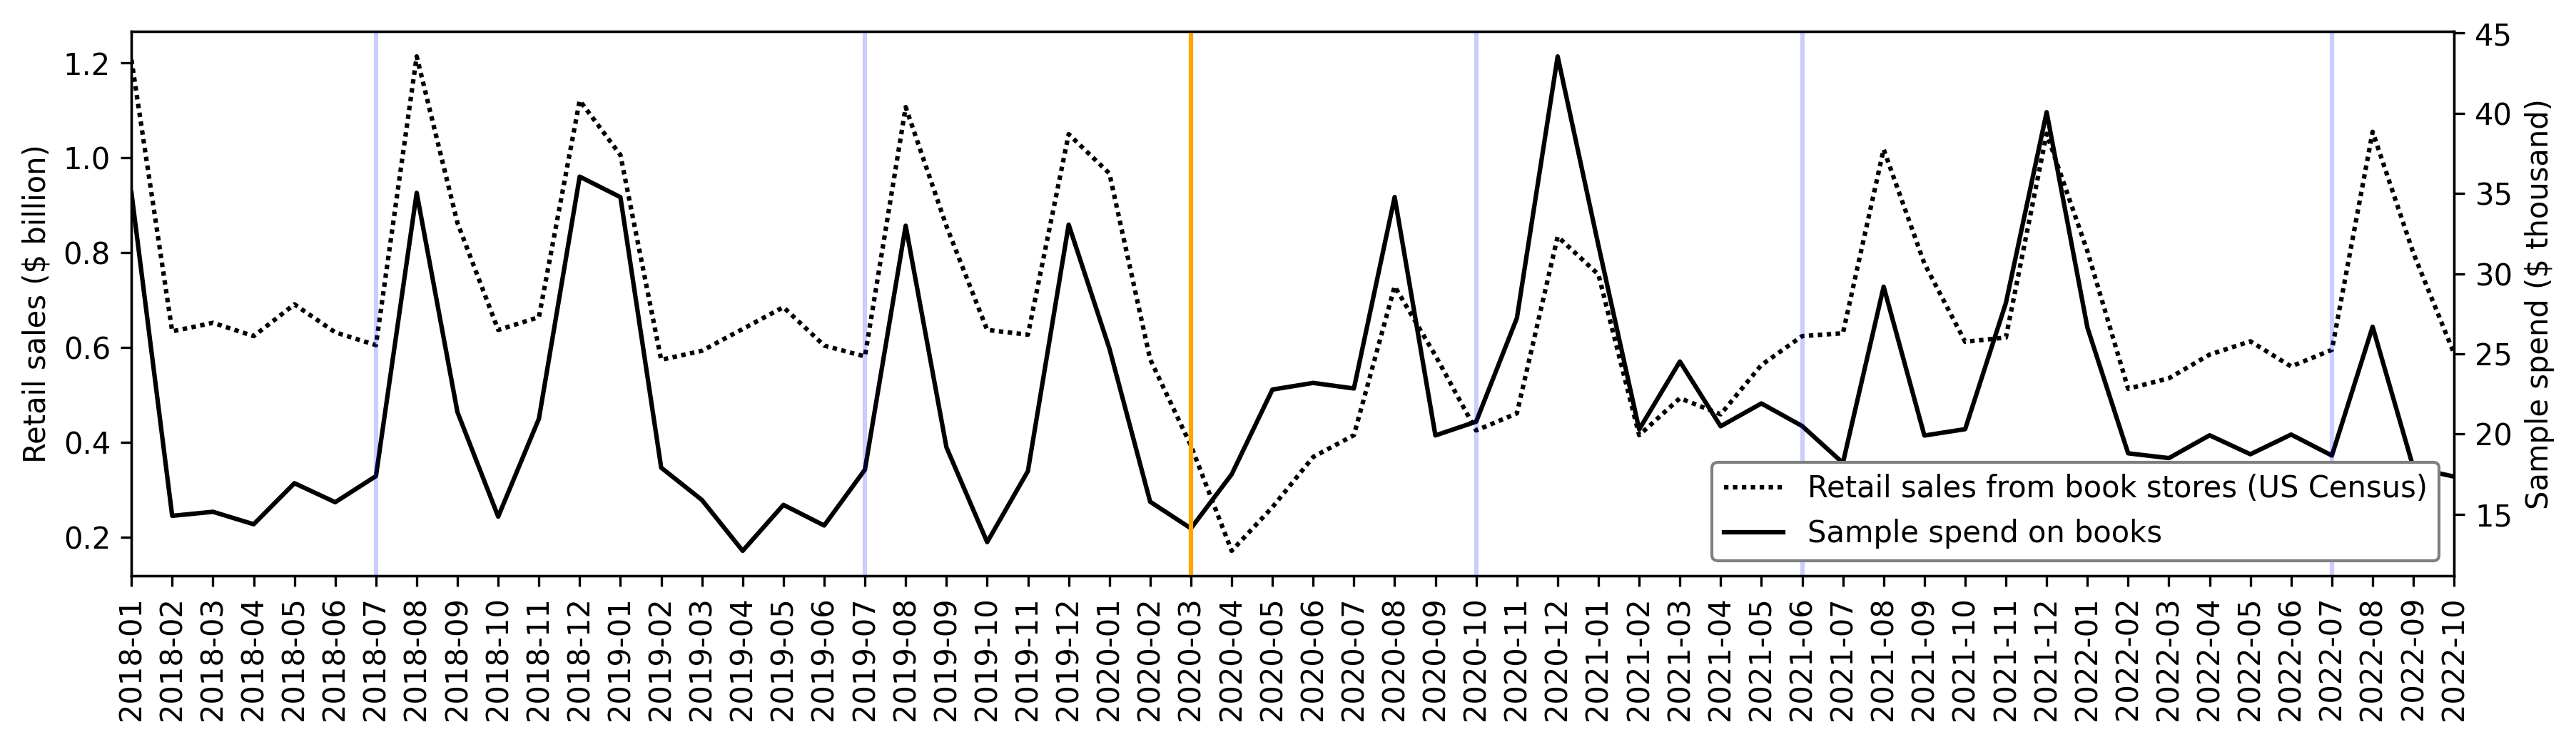

Retail sales for shoe stores vs Amazon shoes sales


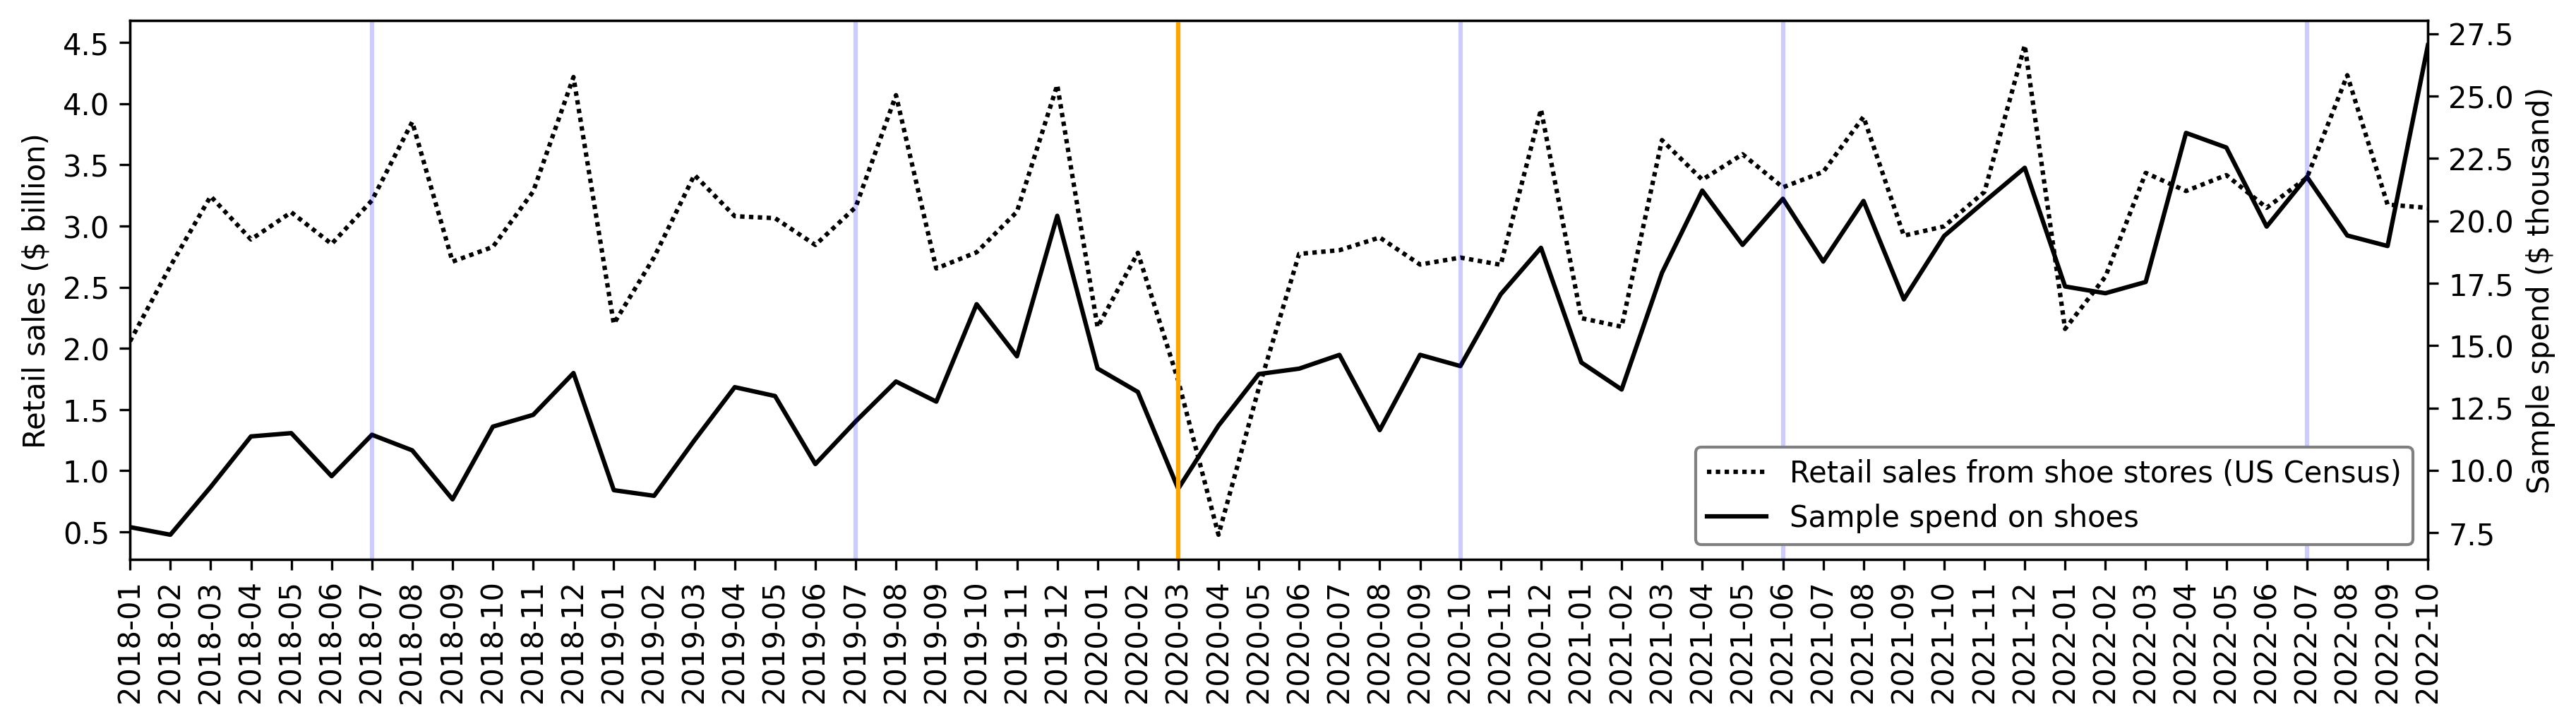

Retail sales for supermarkets and grocery stores vs Amazon groceries sales


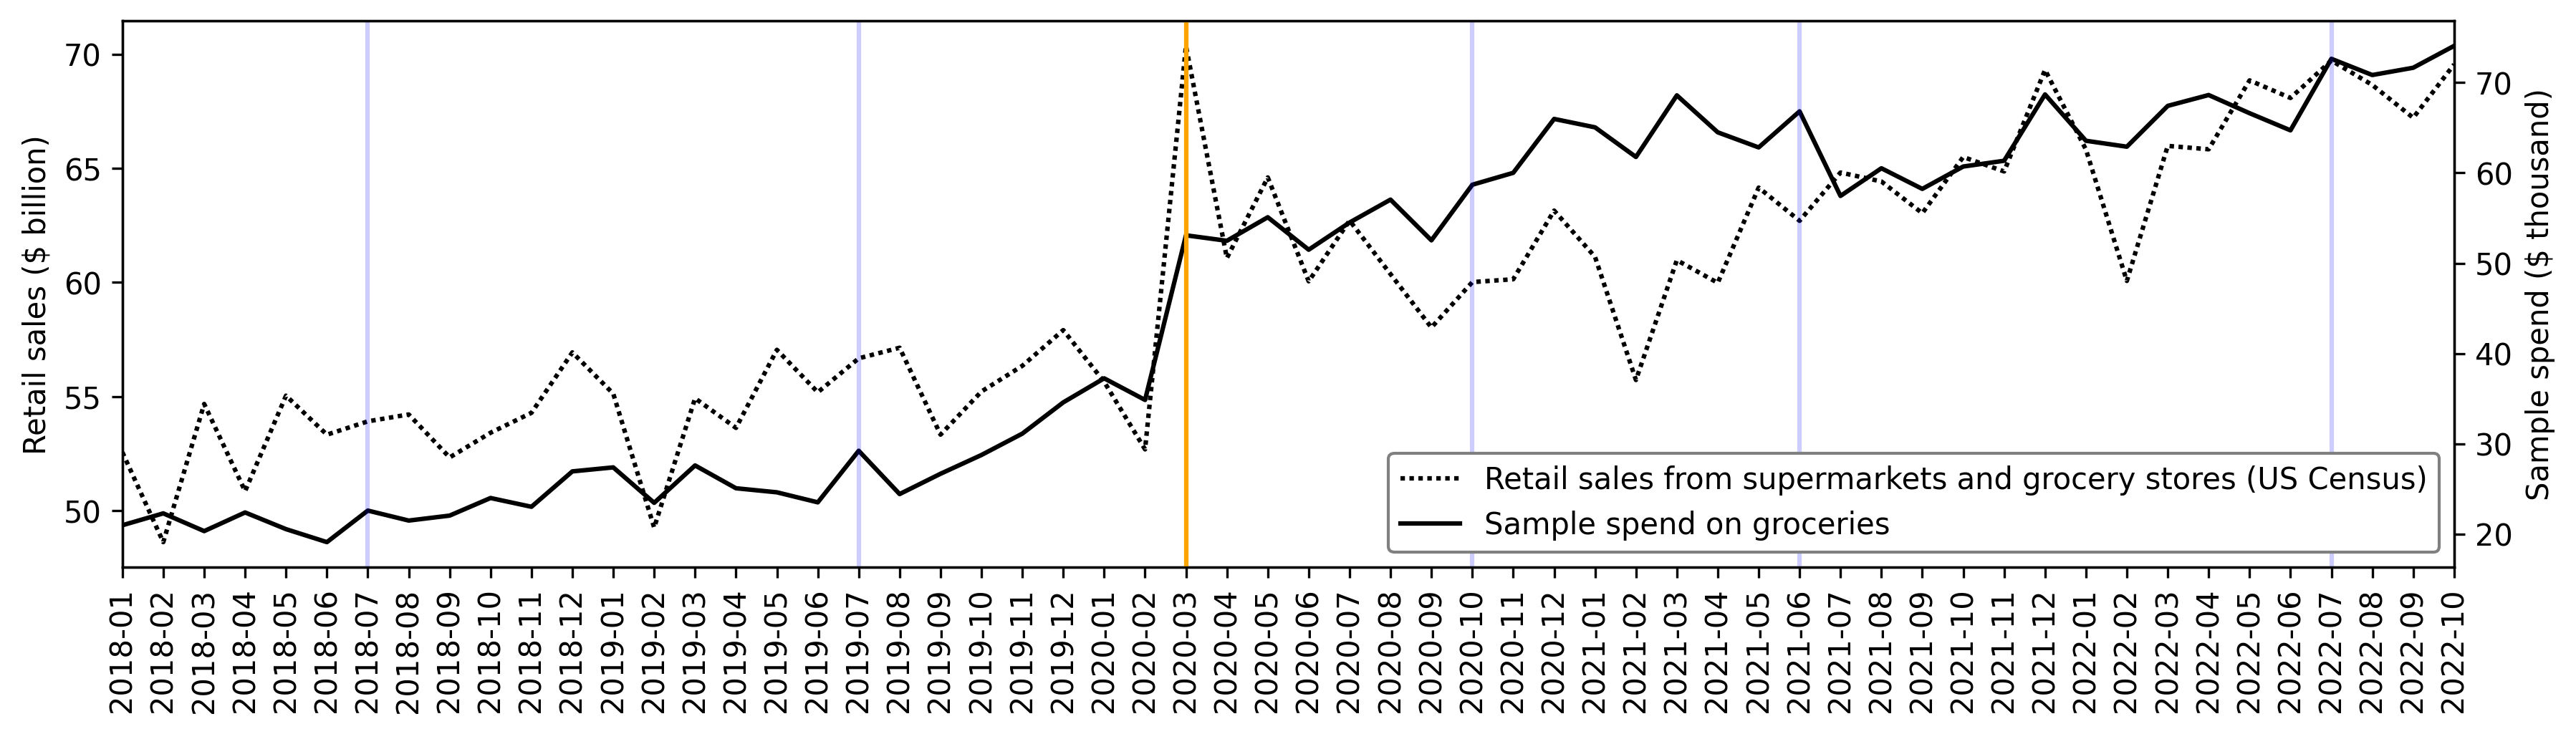

Retail sales for pharmacies and drugs stores vs Amazon pharmacy related products sales


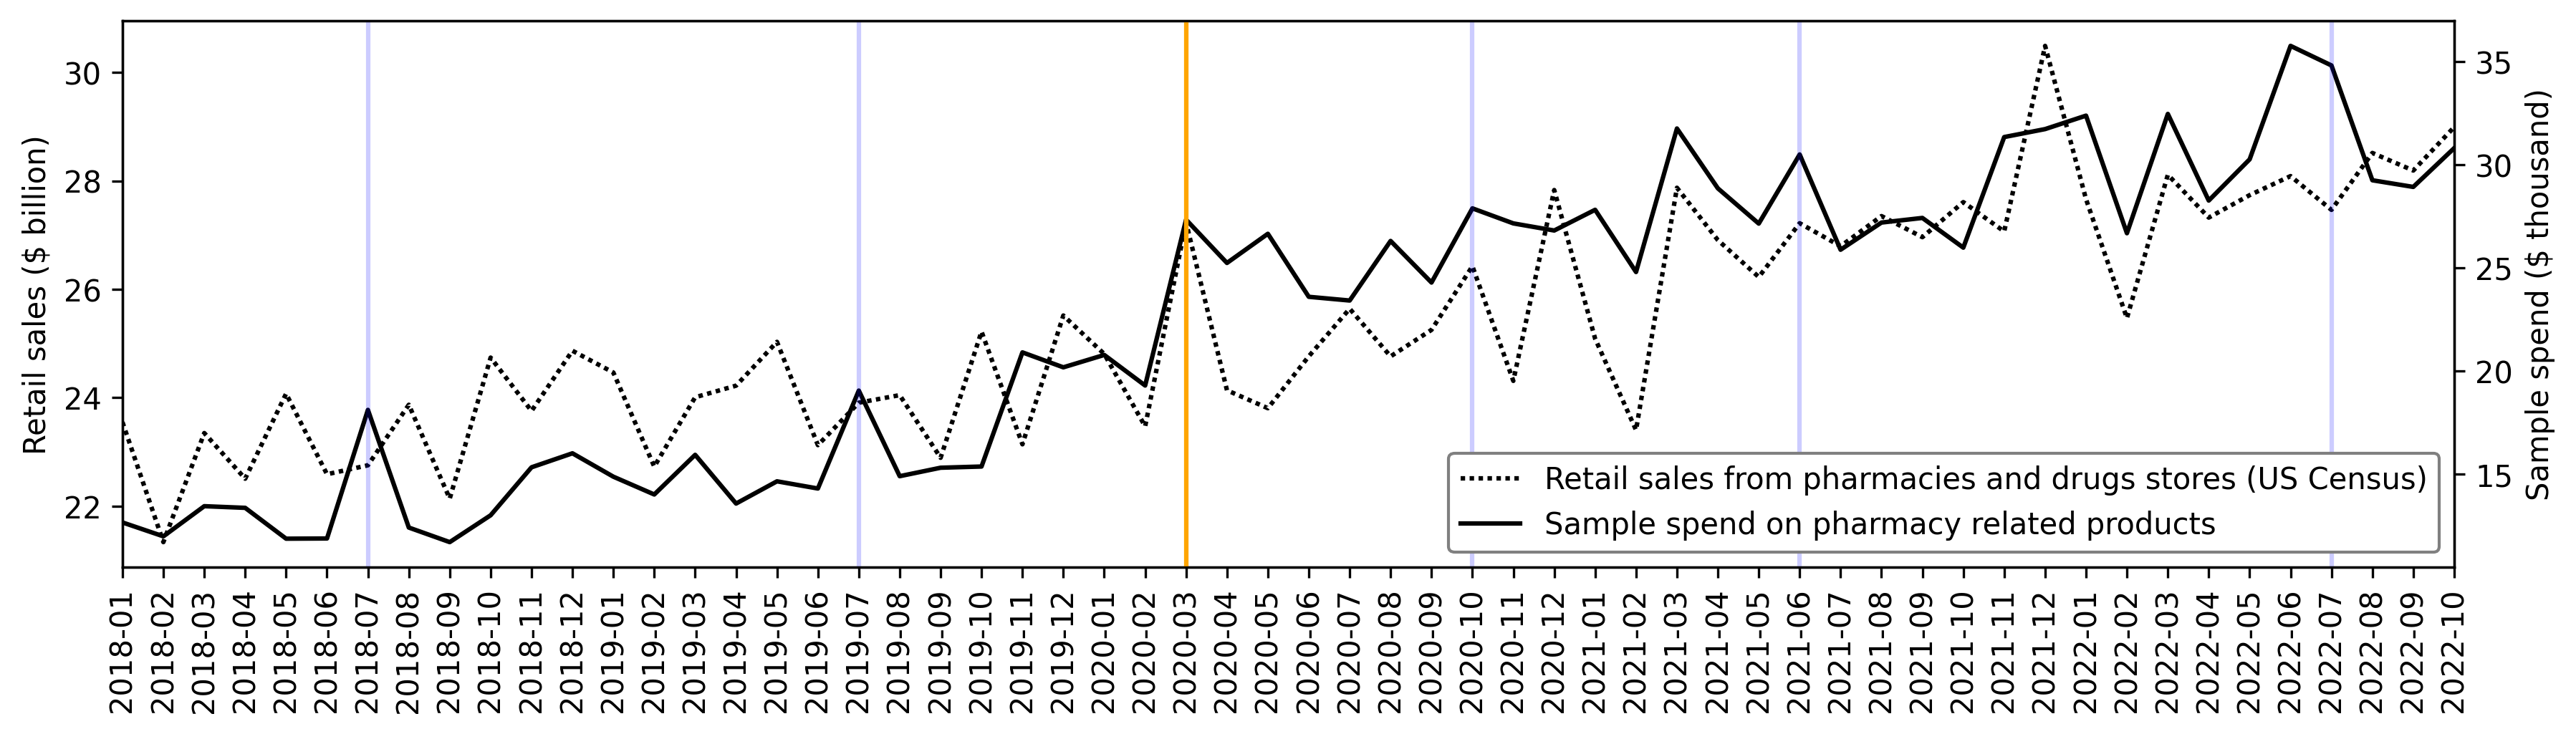

In [214]:
# multiple figures
for i, (label, census_text, amzn_sample_text, amzn_m_data) in enumerate(plt_text_list):
    print('Retail sales for %s vs Amazon %s sales' % (census_text, amzn_sample_text))
    fig, ax = plt.subplots(1,1,figsize=(14,3.3), dpi=300)
    ax.set_ylabel('Retail sales ($ billion)')
    plot_monthly_data(
        retail_sales.reindex(yyyy_mm_idx)[label]/1000, ax=ax,
        label='Retail sales from %s (US Census)'%census_text, color=census_color,
        linestyle=census_linestyle,
        legend=False)
    ax2 = ax.twinx()
    ax2.set_ylabel('Sample spend ($ thousand)')
    plot_monthly_data(
        amzn_m_data/1000, ax=ax2, label='Sample spend on %s'%amzn_sample_text, legend=False, 
        color=amzn_sample_spend_color, show_covid=True, show_prime_dates=True
    )
    plt.legend(
        handles=[ax.get_lines()[0], ax2.get_lines()[0]],
        edgecolor='gray', facecolor='white', framealpha=1, loc='lower right'
    )
    plt.show()

As one figure

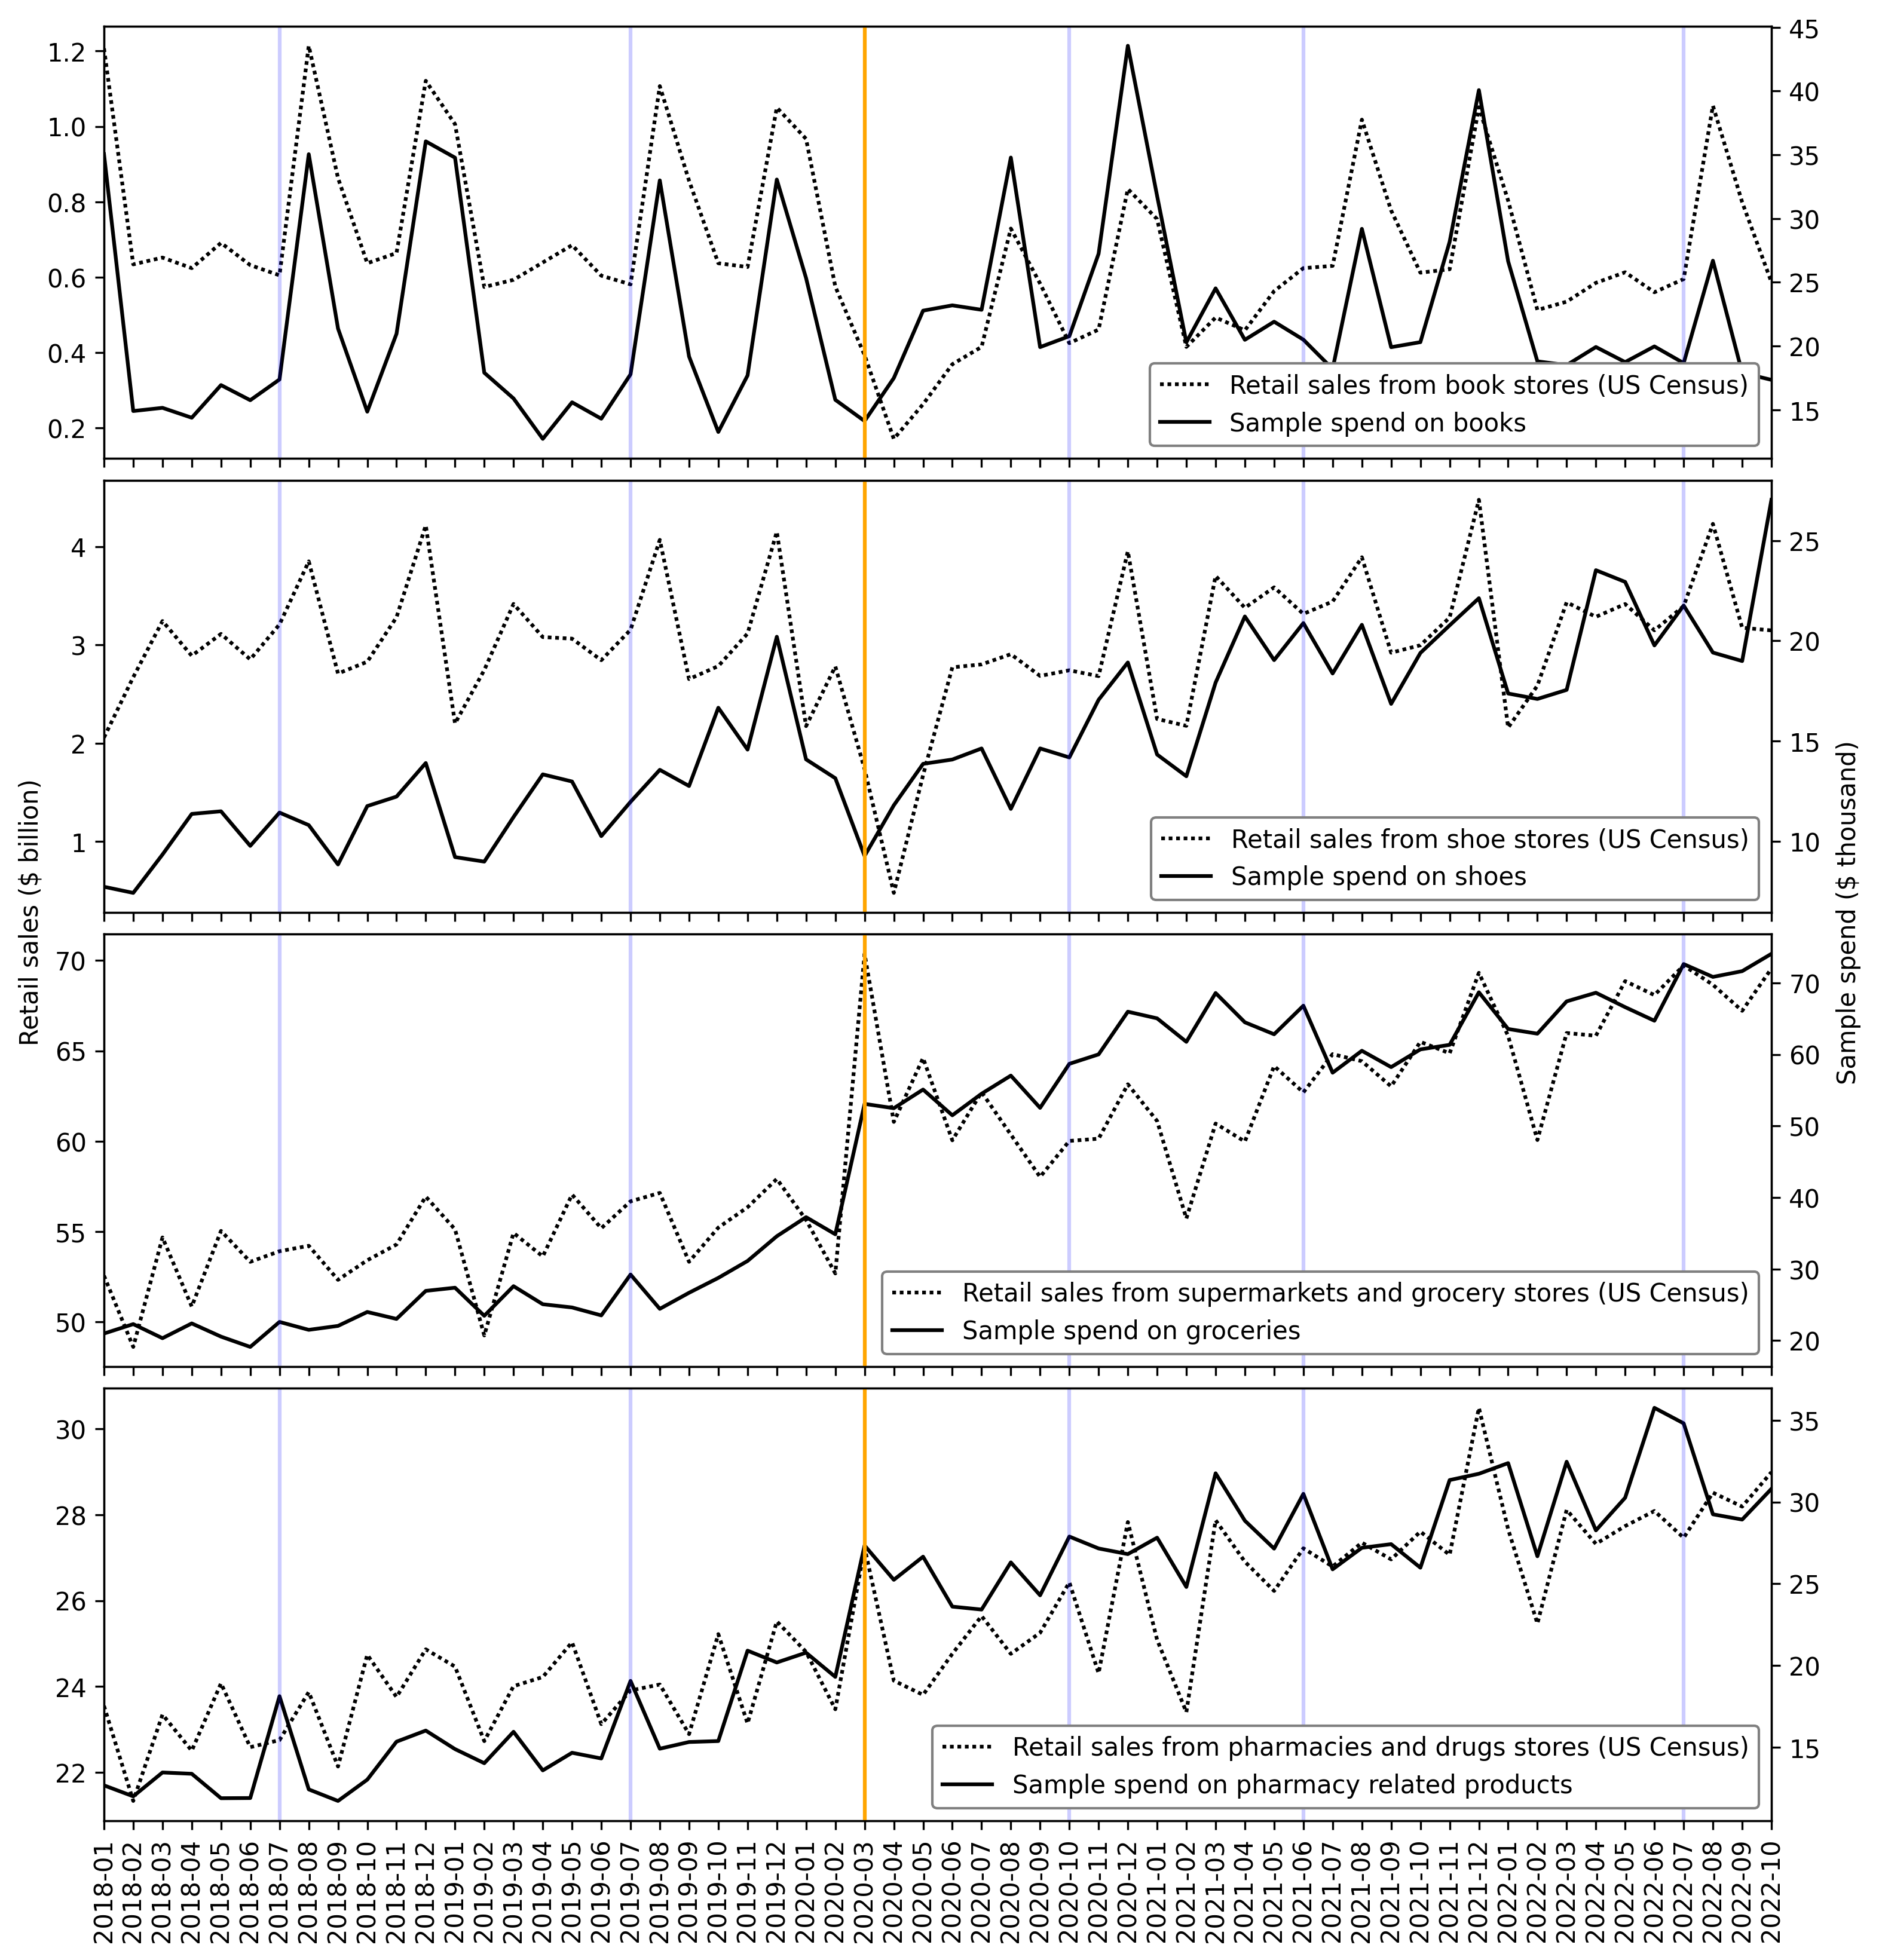

In [237]:
# combined figure
fig, axes = plt.subplots(4,1,figsize=(12,13), sharex=True, dpi=300)
fig.subplots_adjust(hspace=0.05)
for i, (label, census_text, amzn_sample_text, amzn_m_data) in enumerate(plt_text_list):
    ax = axes[i]
    plot_monthly_data(
        retail_sales.reindex(yyyy_mm_idx)[label]/1000, ax=ax,
        label='Retail sales from %s (US Census)'%census_text, color=census_color,
        linestyle=census_linestyle,
        legend=False)
    ax2 = ax.twinx()
    plot_monthly_data(
        amzn_m_data/1000, ax=ax2, label='Sample spend on %s'%amzn_sample_text, legend=False, 
        color=amzn_sample_spend_color, show_covid=True, show_prime_dates=True
    )
    plt.legend(
        handles=[ax.get_lines()[0], ax2.get_lines()[0]],
        edgecolor='gray', facecolor='white', framealpha=1, loc='lower right'
    )
_ = fig.text(0.085, 0.5, 'Retail sales ($ billion)', va='center', rotation=90, fontsize='medium')
_ = fig.text(0.93, 0.5, 'Sample spend ($ thousand)', va='center', rotation=90, fontsize='medium')

## Regression analysis

OLS

According to the National Bureau of Economic Research, the acknowledged arbiter of business-cycle dating, the contraction in economic activity marking the pandemic recession lasted only two months: March and April 2020.

- t: indicates month; starts at t=0:2018-01 and increases with each month

Dummy variables:
- preCovid: 1 if month is before 2020-03
- March2020: 1 if Month is 2020-03; 0 otherwise
- covidYr1: 1 if month in range 2020-04 to 2021-03; 0 otherwise
- covidYr2: 1 if month in range 2021-04 to 2022-03; 0 otherwise
- covidYr3: 1 if month 2022-04 or later; 0 otherwise

RetailSalesDetrended


In [238]:
cats = ['Books','Shoes','Grocery','Pharmacy']

In [239]:
from scipy.signal import detrend

# scale the sales data to start at 1
model_data = pd.DataFrame({
    'RetailSalesBooks': retail_sales.reindex(yyyy_mm_idx)['Book stores']/retail_sales['Book stores'].iloc[0],
    'RetailSalesShoes': retail_sales.reindex(yyyy_mm_idx)['Shoe stores']/retail_sales['Shoe stores'].iloc[0],
    'RetailSalesGrocery': retail_sales.reindex(yyyy_mm_idx)['Grocery']/retail_sales['Grocery'].iloc[0],
    'RetailSalesPharmacy': retail_sales.reindex(yyyy_mm_idx)['Pharmacy']/retail_sales['Pharmacy'].iloc[0],
    'AmznSpendBooks': book_purchases_m/book_purchases_m[0],
    'AmznSpendShoes': shoes_purchases_m/shoes_purchases_m[0],
    'AmznSpendGrocery': groc_purchases_m/groc_purchases_m[0],
    'AmznSpendPharmacy': pharm_plus_purchases_m/pharm_plus_purchases_m[0],
    't': list(range(len(yyyy_mm_idx))),
    YYYY_MM: yyyy_mm_idx,
    'isPrimeMonth': [(1 if ym in amzn_prime_ms else 0) for ym in yyyy_mm_idx],
    'month': (list(range(1,13))*5)[:-2], # [1,2,3,...12,1,2,3,...]
    'preCovid': [(1 if ym<'2020-03' else 0) for ym in yyyy_mm_idx],
    'postCovid': [(1 if ym>'2020-03' else 0) for ym in yyyy_mm_idx],
    'preCovid2019': [(1 if (ym>='2019-03' and ym<='2020-02') else 0) for ym in yyyy_mm_idx],
    'March2020': [(1 if ym=='2020-03' else 0) for ym in yyyy_mm_idx],
    'CovidRecession': [(1 if ym in ['2020-03', '2020-04'] else 0) for ym in yyyy_mm_idx],
    'CovidYr1': [(1 if (ym>='2020-04' and ym<='2021-03') else 0) for ym in yyyy_mm_idx],
    'CovidYr2': [(1 if (ym>='2021-04' and ym<='2022-03') else 0) for ym in yyyy_mm_idx],
    'CovidYr3': [(1 if (ym>='2022-04') else 0) for ym in yyyy_mm_idx],
    'CovidYr12': [(1 if (ym>='2020-04' and ym<='2022-03') else 0) for ym in yyyy_mm_idx],
    'CovidYr23': [(1 if (ym>='2021-04') else 0) for ym in yyyy_mm_idx],
})
for cat in cats:
    model_data['RetailSales%sDetrended'%cat] = detrend(model_data['RetailSales%s'%cat], type='linear')

# weighted version
w_model_data = model_data.copy()
w_model_data['AmznSpendBooks'] = w_book_purchases_m/w_book_purchases_m[0]
w_model_data['AmznSpendShoes'] = w_shoes_purchases_m/w_shoes_purchases_m[0]
w_model_data['AmznSpendGrocery'] = w_groc_purchases_m/w_groc_purchases_m[0]
w_model_data['AmznSpendPharmacy'] = w_pharm_plus_purchases_m/w_pharm_plus_purchases_m[0]

# Add terms for Amazon's market share relative to retail: AmazonSpend/RetailSales
# Patsy can't handle the '/' character, so I use an underscore '_'
for cat in cats:
    model_data['AmznSpend{cat}_RetailSales{cat}'.format(cat=cat)] = \
        model_data['AmznSpend{cat}'.format(cat=cat)]/model_data['RetailSales{cat}'.format(cat=cat)]
    w_model_data['AmznSpend{cat}_RetailSales{cat}'.format(cat=cat)] = \
        w_model_data['AmznSpend{cat}'.format(cat=cat)]/w_model_data['RetailSales{cat}'.format(cat=cat)]
    
w_model_data.head(3)

RetailSalesBooks  RetailSalesShoes  RetailSalesGrocery   
2018-01          1.000000          1.000000            1.000000  \
2018-02          0.525269          1.298348            0.925102   
2018-03          0.540182          1.575802            1.040236   

         RetailSalesPharmacy  AmznSpendBooks  AmznSpendShoes   
2018-01             1.000000        1.000000        1.000000  \
2018-02             0.906026        0.511356        0.865817   
2018-03             0.991465        0.539441        1.291572   

         AmznSpendGrocery  AmznSpendPharmacy  t  yyyy-mm  ...  CovidYr12   
2018-01          1.000000           1.000000  0  2018-01  ...          0  \
2018-02          1.014721           0.978376  1  2018-02  ...          0   
2018-03          0.881927           1.096576  2  2018-03  ...          0   

         CovidYr23  RetailSalesBooksDetrended  RetailSalesShoesDetrended   
2018-01          0                   0.381246                  -0.365754  \
2018-02          0                  -0.091497                  -0.070923   
2018-03          0                  -0.074596                   0.203014   

         RetailSalesGroceryDetrended  RetailSalesPharmacyDetrended   
2018-01                     0.030145                      0.048044  \
2018-02                    -0.050512                     -0.050312   
2018-03                     0.058861                      0.030746   

         AmznSpendBooks_RetailSalesBooks  AmznSpendShoes_RetailSalesShoes   
2018-01                         1.000000                         1.000000  \
2018-02                         0.973511                         0.666860   
2018-03                         0.998627                         0.819629   

         AmznSpendGrocery_RetailSalesGrocery   
2018-01                             1.000000  \
2018-02                             1.096875   
2018-03                             0.847815   

         AmznSpendPharmacy_RetailSalesPharmacy  
2018-01                               1.000000  
2018-02                               1.079854  
2018-03                               1.106017  

[3 rows x 30 columns]

Amazon spend relative to retail sales (weighted)


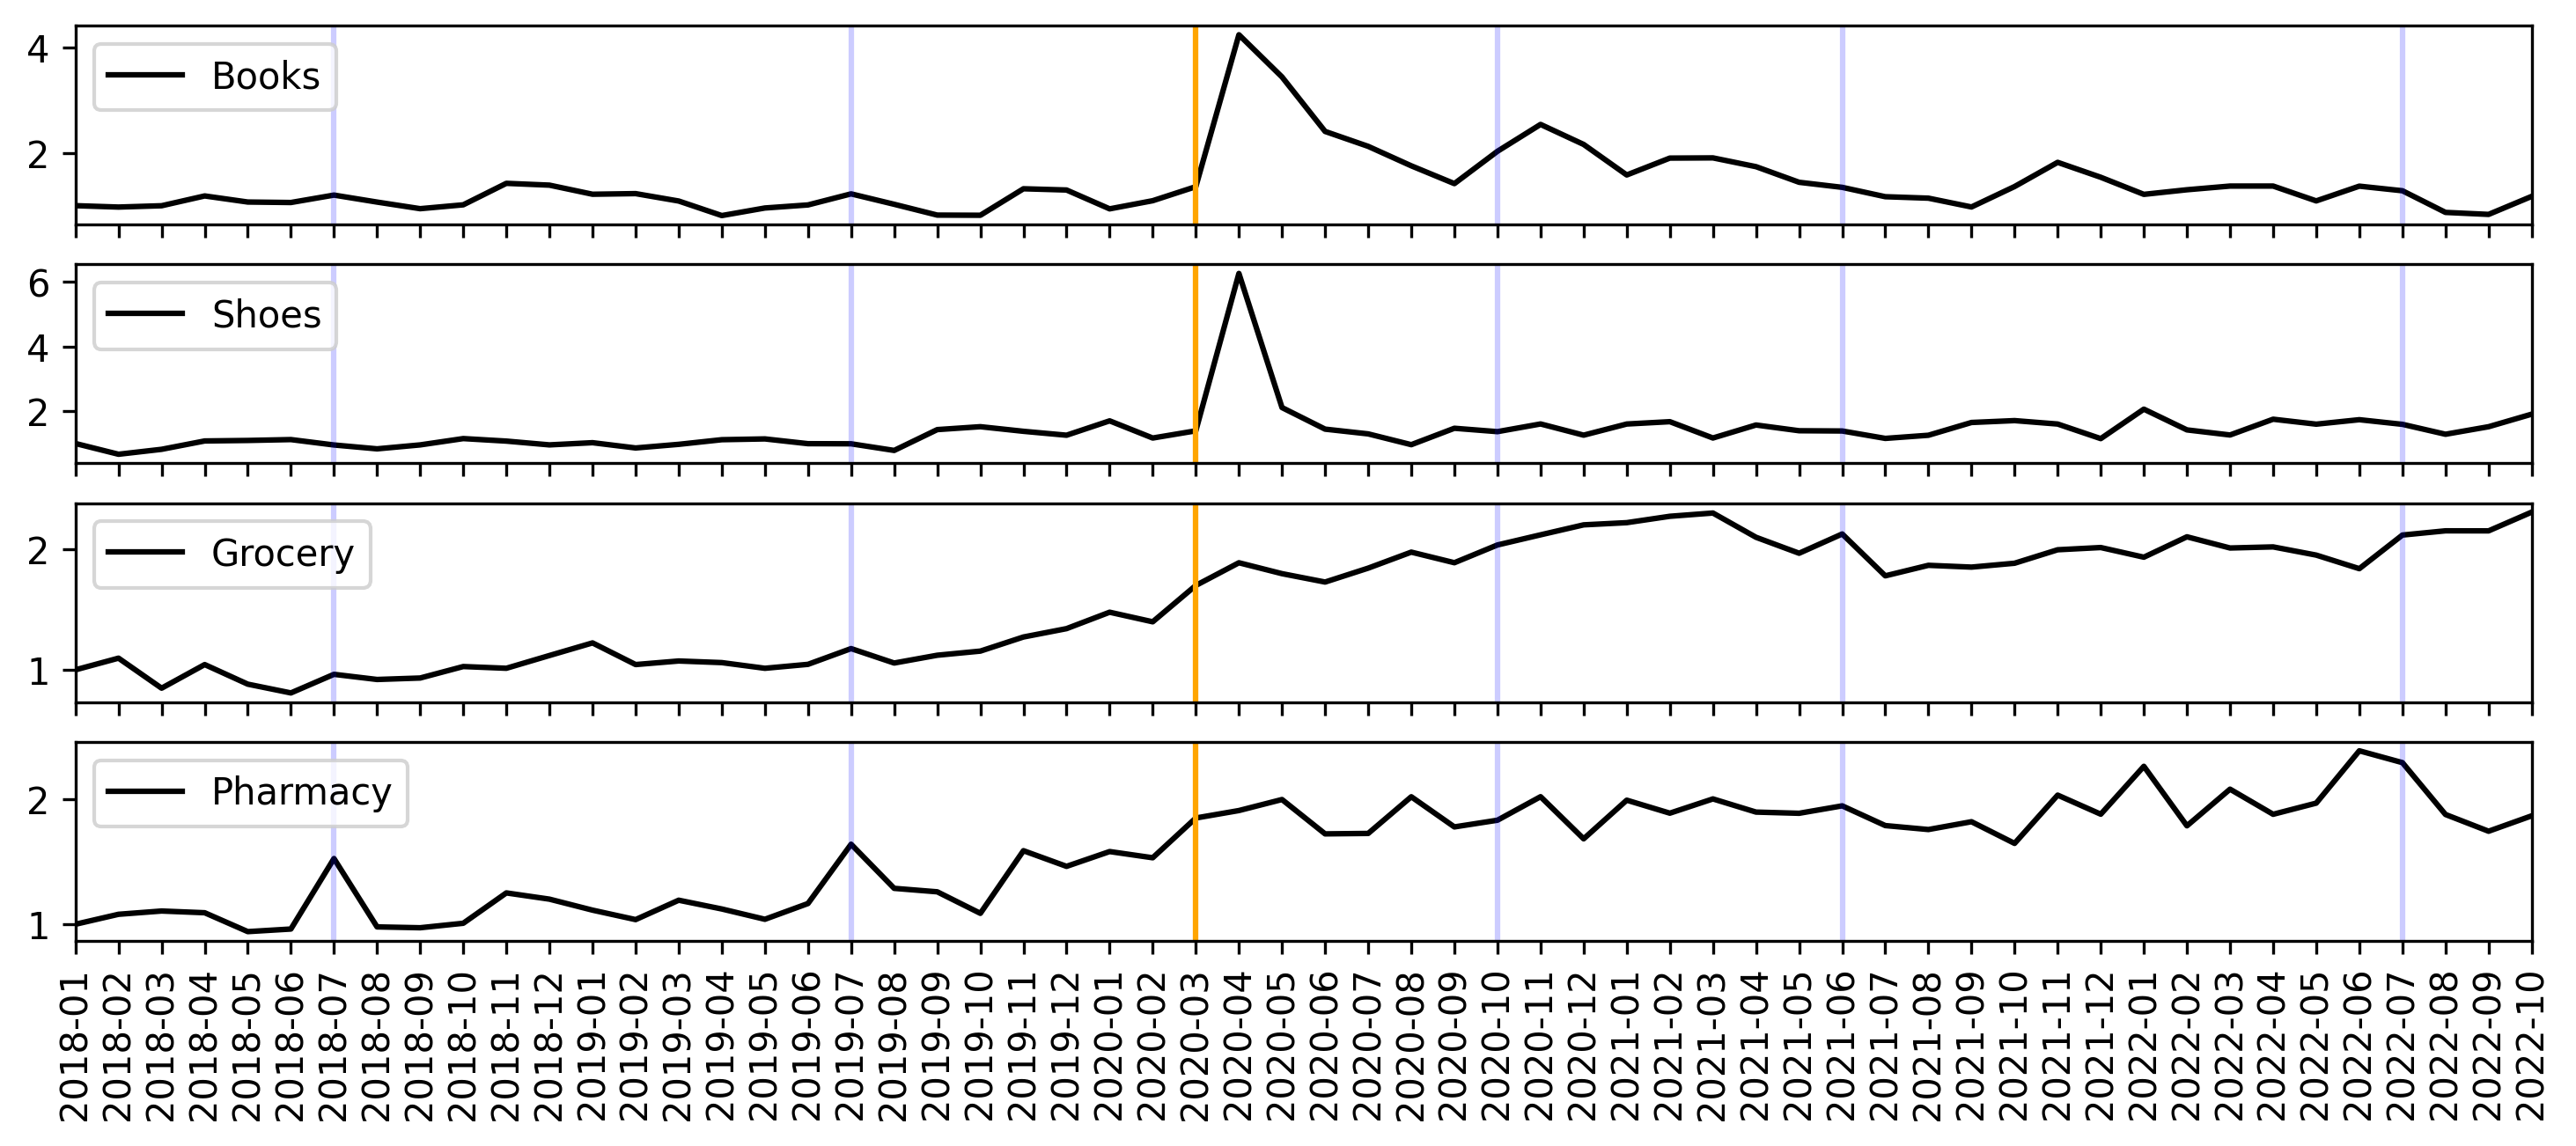

Amazon spend relative to retail sales (unweighted)


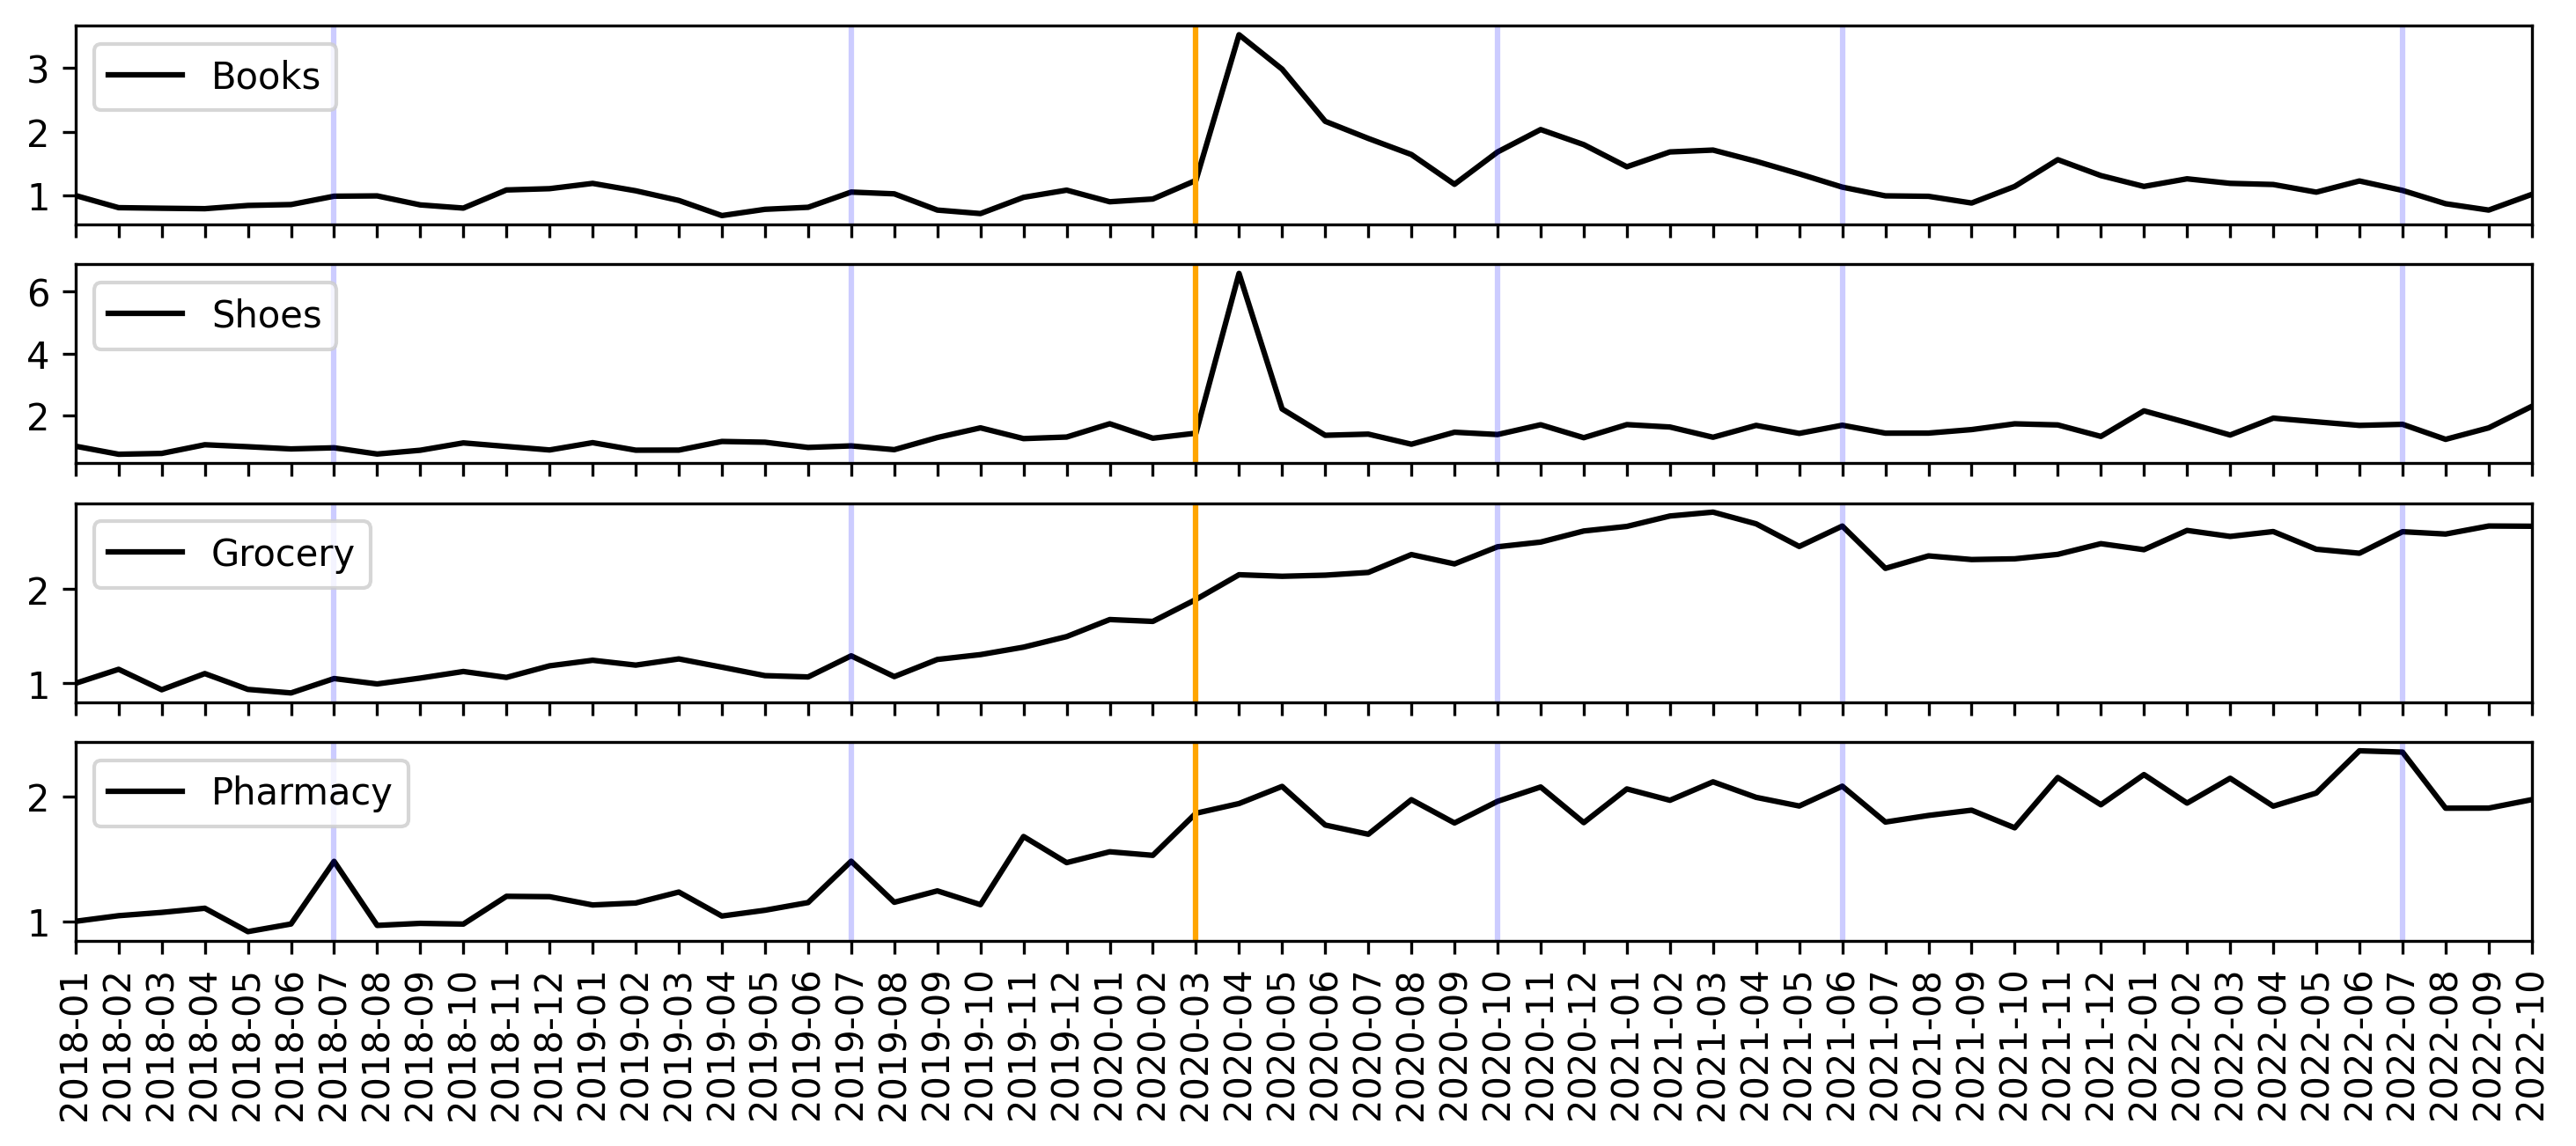

In [259]:
fig, axes = plt.subplots(len(cats), 1, figsize=(12, 4.5), sharex=True, dpi=300)#, sharey=True)
print('Amazon spend relative to retail sales (weighted)')
for c, cat in enumerate(cats):
    ax = axes[c]
    plot_monthly_data(
        w_model_data['AmznSpend{cat}_RetailSales{cat}'.format(cat=cat)], ax=ax, 
        label='%s'%cat, color='black',
        legend=True, show_covid=True, show_prime_dates=True,
    )
    ax.yaxis.get_major_locator().set_params(integer=True)
# fig.subplots_adjust(hspace=0.09)
plt.show()
fig, axes = plt.subplots(len(cats), 1, figsize=(12, 4.5), sharex=True, dpi=300)#, sharey=True)
print('Amazon spend relative to retail sales (unweighted)')
for c, cat in enumerate(cats):
    ax = axes[c]
    plot_monthly_data(
        model_data['AmznSpend{cat}_RetailSales{cat}'.format(cat=cat)], ax=ax, 
        label='%s'%cat, color='black',
        legend=True, show_covid=True, show_prime_dates=True,
    )
    ax.yaxis.get_major_locator().set_params(integer=True)

In [272]:
def get_stars(row):
    if row['p-value'] < 0.001:
        return '***'
    if row['p-value'] < 0.01:
        return '**'
    if row['p-value'] < 0.05:
        return '*'
    return ''


def get_formatted_coef(row, se=True):
    string = '%s%s' % (row['Coef'], get_stars(row))
    if se:
        string += (' (%0.3f)'%row['SE'])
    return string


def get_model_coefs(model, cat, se=True):
    """This is very specific to the model definition."""
    print('R-squared=%0.3f' % model.rsquared)
    table = pd.DataFrame({
            'Coef': model.params.apply(round, args=([3])),
            'p-value': model.pvalues,
            'SE': model.bse,
    })
    table['Coef']=table.apply(lambda r: get_formatted_coef(r, se=se), axis=1)
    table.loc['R-squared'] = [round(model.rsquared, 3), '-', '-']
    return table[['Coef']] 


def print_coefs_model_change(model, cat):
    """This is very specific to the model definition."""
    print('R-squared=%0.3f' % model.rsquared)
    table = pd.DataFrame({
            'Coef': model.params.apply(round, args=([3])),
            'p-value': model.pvalues.apply(round, args=([3])),
            'Change': ['-','-','-', 
            '%0.1f%%'%(100*(model.params['CovidYr1:RetailSales%s'%cat]/model.params['RetailSales%s'%cat])),
            '%0.1f%%'%(100*(model.params['CovidYr2:RetailSales%s'%cat]/model.params['RetailSales%s'%cat])),
            '%0.1f%%'%(100*(model.params['CovidYr3:RetailSales%s'%cat]/model.params['RetailSales%s'%cat]))],
    })
    table['Coef']=table.apply(lambda r: '%s%s' % (r['Coef'], get_stars(r)), axis=1)#.rename('Coef').to_frame()
    display(table[['Coef','Change']])

### Model 1



In [298]:
data = model_data
formula_str = 'AmznSpend{cat}_RetailSales{cat} ~ C(month) + t'
formula_str += ' + March2020 + CovidYr1 + CovidYr2 + CovidYr3'
coefs = dict()
for cat in cats:
    print(formula_str.format(cat=cat))
    result = ols(formula=formula_str.format(cat=cat), data=data).fit()
    #display(result.summary())
    coefs[cat] = get_model_coefs(result, cat)['Coef']
    print('N (obs) = %s' % result.nobs)
pd.DataFrame(coefs)

AmznSpendBooks_RetailSalesBooks ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
R-squared=0.725
N (obs) = 58.0
AmznSpendShoes_RetailSalesShoes ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
R-squared=0.434
N (obs) = 58.0
AmznSpendGrocery_RetailSalesGrocery ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
R-squared=0.972
N (obs) = 58.0
AmznSpendPharmacy_RetailSalesPharmacy ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
R-squared=0.923
N (obs) = 58.0


Books           Shoes           Grocery   
Intercept       0.926*** (0.187)   1.02* (0.403)  1.009*** (0.076)  \
C(month)[T.2]      0.022 (0.203)  -0.303 (0.439)     0.058 (0.083)   
C(month)[T.3]      -0.05 (0.216)  -0.524 (0.466)    -0.024 (0.088)   
C(month)[T.4]      0.359 (0.211)   0.907 (0.455)    -0.034 (0.086)   
C(month)[T.5]      0.222 (0.209)  -0.079 (0.451)   -0.196* (0.086)   
C(month)[T.6]      0.065 (0.207)  -0.286 (0.448)    -0.19* (0.085)   
C(month)[T.7]      0.032 (0.206)  -0.322 (0.446)   -0.173* (0.085)   
C(month)[T.8]     -0.062 (0.206)  -0.566 (0.444)    -0.19* (0.084)   
C(month)[T.9]     -0.271 (0.205)  -0.306 (0.444)   -0.173* (0.084)   
C(month)[T.10]    -0.085 (0.205)  -0.051 (0.443)    -0.132 (0.084)   
C(month)[T.11]     0.215 (0.216)  -0.226 (0.467)    -0.129 (0.088)   
C(month)[T.12]     0.131 (0.217)  -0.457 (0.468)    -0.033 (0.089)   
t                 -0.004 (0.008)   0.017 (0.018)  0.021*** (0.003)   
March2020          0.471 (0.378)   0.477 (0.817)    0.363* (0.155)   
CovidYr1        1.142*** (0.203)   0.522 (0.438)  0.837*** (0.083)   
CovidYr2           0.422 (0.292)  -0.006 (0.630)   0.62*** (0.119)   
CovidYr3           0.293 (0.388)  -0.109 (0.839)  0.584*** (0.159)   
R-squared                  0.725           0.434             0.972   

                        Pharmacy  
Intercept       1.035*** (0.083)  
C(month)[T.2]     -0.075 (0.090)  
C(month)[T.3]     -0.008 (0.096)  
C(month)[T.4]     -0.071 (0.093)  
C(month)[T.5]     -0.083 (0.092)  
C(month)[T.6]     -0.039 (0.092)  
C(month)[T.7]      0.036 (0.091)  
C(month)[T.8]     -0.175 (0.091)  
C(month)[T.9]      -0.2* (0.091)  
C(month)[T.10]   -0.221* (0.091)  
C(month)[T.11]     0.091 (0.096)  
C(month)[T.12]    -0.106 (0.096)  
t               0.018*** (0.004)  
March2020         0.373* (0.168)  
CovidYr1        0.389*** (0.090)  
CovidYr2           0.208 (0.129)  
CovidYr3            0.17 (0.172)  
R-squared                  0.923

#### Robustness check:

Again with weighted data

In [299]:
print('Weigthed data\n')
data = w_model_data
coefs = dict()
for cat in cats:
    print(formula_str.format(cat=cat))
    result = ols(formula=formula_str.format(cat=cat), data=data).fit()
    #display(result.summary())
    print('N (obs) = %s' % result.nobs)
    coefs[cat] = get_model_coefs(result, cat)['Coef']
pd.DataFrame(coefs)

Weigthed data

AmznSpendBooks_RetailSalesBooks ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
N (obs) = 58.0
R-squared=0.743
AmznSpendShoes_RetailSalesShoes ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
N (obs) = 58.0
R-squared=0.407
AmznSpendGrocery_RetailSalesGrocery ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
N (obs) = 58.0
R-squared=0.966
AmznSpendPharmacy_RetailSalesPharmacy ~ C(month) + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3
N (obs) = 58.0
R-squared=0.896


Books            Shoes           Grocery   
Intercept        1.0*** (0.213)  1.051** (0.383)  0.988*** (0.062)  \
C(month)[T.2]     0.117 (0.232)   -0.334 (0.417)    -0.004 (0.068)   
C(month)[T.3]     0.072 (0.246)    -0.47 (0.442)    -0.096 (0.072)   
C(month)[T.4]    0.625* (0.240)    0.861 (0.431)    -0.076 (0.070)   
C(month)[T.5]     0.363 (0.238)   -0.041 (0.428)  -0.192** (0.070)   
C(month)[T.6]     0.211 (0.236)   -0.186 (0.425)   -0.22** (0.069)   
C(month)[T.7]     0.179 (0.235)   -0.338 (0.423)    -0.17* (0.069)   
C(month)[T.8]    -0.041 (0.234)   -0.526 (0.421)   -0.167* (0.069)   
C(month)[T.9]    -0.207 (0.234)    -0.16 (0.421)  -0.188** (0.069)   
C(month)[T.10]    0.083 (0.234)   -0.049 (0.421)    -0.111 (0.068)   
C(month)[T.11]   0.522* (0.246)   -0.142 (0.443)    -0.085 (0.072)   
C(month)[T.12]     0.35 (0.247)   -0.415 (0.444)    -0.032 (0.072)   
t                -0.008 (0.010)    0.014 (0.017)  0.016*** (0.003)   
March2020         0.486 (0.431)    0.439 (0.775)   0.399** (0.126)   
CovidYr1        1.35*** (0.231)    0.485 (0.415)  0.635*** (0.068)   
CovidYr2           0.52 (0.333)    -0.07 (0.598)  0.393*** (0.097)   
CovidYr3          0.383 (0.443)   -0.135 (0.796)     0.4** (0.130)   
R-squared                 0.743            0.407             0.966   

                        Pharmacy  
Intercept       1.068*** (0.090)  
C(month)[T.2]     -0.143 (0.098)  
C(month)[T.3]     -0.053 (0.104)  
C(month)[T.4]      -0.08 (0.101)  
C(month)[T.5]     -0.111 (0.100)  
C(month)[T.6]     -0.059 (0.100)  
C(month)[T.7]      0.081 (0.099)  
C(month)[T.8]     -0.148 (0.099)  
C(month)[T.9]    -0.235* (0.099)  
C(month)[T.10]   -0.28** (0.099)  
C(month)[T.11]     0.039 (0.104)  
C(month)[T.12]    -0.146 (0.104)  
t               0.018*** (0.004)  
March2020          0.365 (0.182)  
CovidYr1         0.321** (0.097)  
CovidYr2           0.121 (0.140)  
CovidYr3           0.077 (0.186)  
R-squared                  0.896

---

### Model 2

$$AmznUserSpend_t = constant + retailSalesDetrended_t + t + march2020 + covidYr1 + covidYr2 + covidYr3 + [month_m] $$


Here we find what might be substitution effects for grocery: a stat. significant coefficient for $retailSalesDetrended$

However, this does not hold for the weighted data. 

We do not use this model.

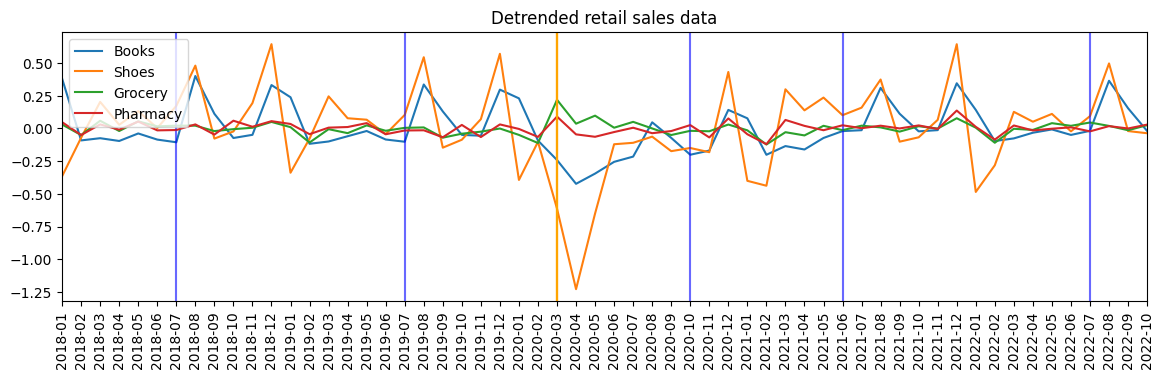

In [242]:
# we don't end up using this
fig, ax = plt.subplots(1,1,figsize=(14,3.5))#, dpi=300)
for cat in cats:
    plot_monthly_data(
        model_data['RetailSales%sDetrended'%cat], ax=ax, label='%s'%cat, 
        legend=True, show_covid=True, show_prime_dates=True,
    )
_ = ax.set_title('Detrended retail sales data')

In [280]:
formula_str = 'AmznSpend{cat} ~ t + March2020'
formula_str += ' + CovidYr1 + CovidYr2 + CovidYr3'
formula_str += ' + RetailSales{cat}Detrended'
formula_str += ' + C(month)'
coefs = dict()
for cat in cats:
    print(formula_str.format(cat=cat))
    result = ols(formula=formula_str.format(cat=cat), data=model_data).fit()
    coefs[cat] = get_model_coefs(result, cat)['Coef'].rename({
        'preCovid:RetailSales%sDetrended'%cat: 'preCovid x RetailSalesDetrended',
        'CovidYr1:RetailSales%sDetrended'%cat: 'CovidYr1 x RetailSalesDetrended',
        'CovidYr23:RetailSales%sDetrended'%cat: 'postCovdYr1 x RetailSalesDetrended',
        'RetailSales%sDetrended'%cat: 'RetailSalesDetrended',
    })
pd.DataFrame(coefs)

AmznSpendBooks ~ t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + RetailSalesBooksDetrended + C(month)
R-squared=0.917
AmznSpendShoes ~ t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + RetailSalesShoesDetrended + C(month)
R-squared=0.930
AmznSpendGrocery ~ t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + RetailSalesGroceryDetrended + C(month)
R-squared=0.987
AmznSpendPharmacy ~ t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + RetailSalesPharmacyDetrended + C(month)
R-squared=0.951


Books             Shoes            Grocery   
Intercept              0.735*** (0.070)  1.112*** (0.119)   1.117*** (0.080)  \
C(month)[T.2]           -0.176* (0.085)    -0.201 (0.122)   -0.335** (0.120)   
C(month)[T.3]           -0.184* (0.081)     -0.16 (0.159)      0.013 (0.083)   
C(month)[T.4]           -0.198* (0.095)    0.288* (0.126)    -0.206* (0.087)   
C(month)[T.5]            -0.166 (0.084)     0.154 (0.134)     -0.102 (0.086)   
C(month)[T.6]           -0.173* (0.084)    -0.022 (0.134)   -0.266** (0.080)   
C(month)[T.7]           -0.168* (0.082)    -0.012 (0.140)     -0.118 (0.082)   
C(month)[T.8]            -0.025 (0.048)    -0.229 (0.167)    -0.197* (0.079)   
C(month)[T.9]         -0.246*** (0.055)     -0.14 (0.127)  -0.358*** (0.087)   
C(month)[T.10]         -0.214** (0.078)     0.253 (0.129)     -0.157 (0.079)   
C(month)[T.11]           -0.049 (0.076)     0.146 (0.144)     -0.161 (0.083)   
C(month)[T.12]          0.167** (0.051)       0.2 (0.198)      0.187 (0.096)   
t                        -0.004 (0.002)   0.03*** (0.005)   0.018*** (0.004)   
March2020                 0.093 (0.094)    -0.248 (0.261)   1.467*** (0.287)   
CovidYr1               0.329*** (0.058)    -0.108 (0.127)   1.237*** (0.100)   
CovidYr2                0.205** (0.066)    -0.024 (0.169)   1.227*** (0.148)   
CovidYr3                  0.175 (0.089)       0.0 (0.226)   1.503*** (0.208)   
RetailSalesDetrended    0.589** (0.214)   0.479** (0.155)    -2.402* (0.972)   
R-squared                         0.917              0.93              0.987   

                              Pharmacy  
Intercept             1.021*** (0.093)  
C(month)[T.2]           -0.195 (0.117)  
C(month)[T.3]            0.046 (0.103)  
C(month)[T.4]           -0.131 (0.102)  
C(month)[T.5]           -0.134 (0.099)  
C(month)[T.6]           -0.068 (0.100)  
C(month)[T.7]           -0.007 (0.099)  
C(month)[T.8]          -0.208* (0.097)  
C(month)[T.9]          -0.264* (0.102)  
C(month)[T.10]         -0.209* (0.099)  
C(month)[T.11]           0.033 (0.106)  
C(month)[T.12]          -0.004 (0.118)  
t                     0.022*** (0.004)  
March2020               0.508* (0.190)  
CovidYr1              0.441*** (0.096)  
CovidYr2                0.382* (0.148)  
CovidYr3                0.399* (0.193)  
RetailSalesDetrended     0.148 (0.836)  
R-squared                        0.951

In [281]:
formula_str = 'AmznSpend{cat} ~ RetailSales{cat}Detrended + t'
formula_str += ' + March2020 + CovidYr1 + CovidYr2 + CovidYr3'
formula_str += ' + C(month)'
coefs = dict()
for cat in cats:
    print(formula_str.format(cat=cat))
    result = ols(formula=formula_str.format(cat=cat), data=w_model_data).fit()
    display(result.summary())
    coefs[cat] = get_model_coefs(result, cat)['Coef'].rename({
        'RetailSales%sDetrended'%cat: 'RetailSalesDetrended'})
pd.DataFrame(coefs)

AmznSpendBooks ~ RetailSalesBooksDetrended + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + C(month)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         AmznSpendBooks   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     36.90
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           3.87e-19
Time:                        16:52:21   Log-Likelihood:                 85.311
No. Observations:                  58   AIC:                            -134.6
Df Residuals:                      40   BIC:                            -97.53
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.8080      0.065     12.380      0.000       0.676       0.940
C(month)[T.2]                -0.1611      0.078     -2.054      0.047      -0.320      -0.003
C(month)[T.3]                -0.1491      0.075     -1.995      0.053      -0.300       0.002
C(month)[T.4]                -0.1471      0.088     -1.679      0.101      -0.324       0.030
C(month)[T.5]                -0.1405      0.078     -1.811      0.078      -0.297       0.016
C(month)[T.6]                -0.1336      0.078     -1.721      0.093      -0.291       0.023
C(month)[T.7]                -0.1256      0.076     -1.651      0.106      -0.279       0.028
C(month)[T.8]                 0.0001      0.045      0.003      0.997      -0.091       0.091
C(month)[T.9]                -0.2192      0.051     -4.333      0.000      -0.321      -0.117
C(month)[T.10]               -0.1618      0.073     -2.229      0.031      -0.308      -0.015
C(month)[T.11]                0.0775      0.071      1.096      0.280      -0.065       0.220
C(month)[T.12]                0.3615      0.048      7.588      0.000       0.265       0.458
RetailSalesBooksDetrended     0.5423      0.198      2.734      0.009       0.141       0.943
t                            -0.0057      0.002     -3.242      0.002      -0.009      -0.002
March2020                     0.0626      0.087      0.722      0.474      -0.113       0.238
CovidYr1                      0.3686      0.054      6.824      0.000       0.259       0.478
CovidYr2                      0.2558      0.061      4.197      0.000       0.133       0.379
CovidYr3                      0.2259      0.083      2.737      0.009       0.059       0.393
==============================================================================
Omnibus:                        0.413   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.813   Jarque-Bera (JB):                0.083
Skew:                          -0.072   Prob(JB):                        0.959
Kurtosis:                       3.116   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared=0.940
AmznSpendShoes ~ RetailSalesShoesDetrended + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + C(month)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         AmznSpendShoes   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     25.91
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           2.32e-16
Time:                        16:52:21   Log-Likelihood:                 30.720
No. Observations:                  58   AIC:                            -25.44
Df Residuals:                      40   BIC:                             11.65
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.1786      0.110     10.758      0.000       0.957       1.400
C(month)[T.2]                -0.2471      0.112     -2.199      0.034      -0.474      -0.020
C(month)[T.3]                -0.0965      0.146     -0.660      0.513      -0.392       0.199
C(month)[T.4]                 0.2738      0.116      2.360      0.023       0.039       0.508
C(month)[T.5]                 0.2022      0.123      1.642      0.109      -0.047       0.451
C(month)[T.6]                 0.0970      0.123      0.789      0.435      -0.151       0.345
C(month)[T.7]                -0.0591      0.129     -0.457      0.650      -0.320       0.202
C(month)[T.8]                -0.1803      0.154     -1.171      0.248      -0.491       0.131
C(month)[T.9]                 0.0489      0.117      0.418      0.678      -0.188       0.285
C(month)[T.10]                0.2412      0.119      2.033      0.049       0.001       0.481
C(month)[T.11]                0.2642      0.132      2.000      0.052      -0.003       0.531
C(month)[T.12]                0.2410      0.182      1.323      0.193      -0.127       0.609
RetailSalesShoesDetrended     0.4497      0.142      3.159      0.003       0.162       0.737
t                             0.0253      0.004      5.646      0.000       0.016       0.034
March2020                    -0.2892      0.240     -1.205      0.235      -0.774       0.196
CovidYr1                     -0.1195      0.117     -1.021      0.314      -0.356       0.117
CovidYr2                     -0.1130      0.156     -0.726      0.472      -0.428       0.202
CovidYr3                     -0.0151      0.207     -0.073      0.942      -0.434       0.404
==============================================================================
Omnibus:                        2.673   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                2.466
Skew:                          -0.424   Prob(JB):                        0.291
Kurtosis:                       2.450   Cond. No.                         592.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared=0.917
AmznSpendGrocery ~ RetailSalesGroceryDetrended + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + C(month)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       AmznSpendGrocery   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     117.8
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           9.99e-29
Time:                        16:52:21   Log-Likelihood:                 53.346
No. Observations:                  58   AIC:                            -70.69
Df Residuals:                      40   BIC:                            -33.60
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.0367      0.075     13.735      0.000       0.884       1.189
C(month)[T.2]                  -0.2311      0.113     -2.046      0.047      -0.459      -0.003
C(month)[T.3]                  -0.0791      0.078     -1.011      0.318      -0.237       0.079
C(month)[T.4]                  -0.1840      0.082     -2.238      0.031      -0.350      -0.018
C(month)[T.5]                  -0.1484      0.081     -1.824      0.076      -0.313       0.016
C(month)[T.6]                  -0.2805      0.075     -3.718      0.001      -0.433      -0.128
C(month)[T.7]                  -0.1442      0.077     -1.874      0.068      -0.300       0.011
C(month)[T.8]                  -0.1746      0.075     -2.341      0.024      -0.325      -0.024
C(month)[T.9]                  -0.3017      0.082     -3.688      0.001      -0.467      -0.136
C(month)[T.10]                 -0.1186      0.074     -1.597      0.118      -0.269       0.031
C(month)[T.11]                 -0.1010      0.078     -1.293      0.203      -0.259       0.057
C(month)[T.12]                  0.0998      0.091      1.100      0.278      -0.084       0.283
RetailSalesGroceryDetrended    -0.8859      0.916     -0.968      0.339      -2.737       0.965
t                               0.0167      0.004      4.048      0.000       0.008       0.025
March2020                       1.0774      0.270      3.984      0.000       0.531       1.624
CovidYr1                        0.8884      0.094      9.414      0.000       0.698       1.079
CovidYr2                        0.7587      0.140      5.425      0.000       0.476       1.041
CovidYr3                        0.9691      0.196      4.938      0.000       0.572       1.366
==============================================================================
Omnibus:                        6.865   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.740
Skew:                           0.538   Prob(JB):                       0.0344
Kurtosis:                       4.278   Cond. No.                     2.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared=0.980
AmznSpendPharmacy ~ RetailSalesPharmacyDetrended + t + March2020 + CovidYr1 + CovidYr2 + CovidYr3 + C(month)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      AmznSpendPharmacy   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     33.26
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           2.60e-18
Time:                        16:52:21   Log-Likelihood:                 32.833
No. Observations:                  58   AIC:                            -29.67
Df Residuals:                      40   BIC:                             7.422
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.0628      0.101     10.496      0.000       0.858       1.267
C(month)[T.2]                   -0.2787      0.128     -2.178      0.035      -0.537      -0.020
C(month)[T.3]                   -0.0063      0.113     -0.056      0.956      -0.234       0.222
C(month)[T.4]                   -0.1459      0.111     -1.312      0.197      -0.371       0.079
C(month)[T.5]                   -0.1671      0.108     -1.542      0.131      -0.386       0.052
C(month)[T.6]                   -0.0949      0.110     -0.866      0.392      -0.316       0.127
C(month)[T.7]                    0.0336      0.108      0.311      0.758      -0.185       0.252
C(month)[T.8]                   -0.1853      0.106     -1.745      0.089      -0.400       0.029
C(month)[T.9]                   -0.3127      0.111     -2.812      0.008      -0.537      -0.088
C(month)[T.10]                  -0.2769      0.108     -2.567      0.014      -0.495      -0.059
C(month)[T.11]                  -0.0297      0.116     -0.255      0.800      -0.265       0.206
C(month)[T.12]                  -0.0448      0.129     -0.348      0.730      -0.305       0.215
RetailSalesPharmacyDetrended     0.0107      0.914      0.012      0.991      -1.837       1.859
t                                0.0219      0.005      4.780      0.000       0.013       0.031
March2020                        0.5129      0.208      2.470      0.018       0.093       0.933
CovidYr1                         0.3683      0.105      3.512      0.001       0.156       0.580
CovidYr2                         0.2930      0.162      1.810      0.078      -0.034       0.620
CovidYr3                         0.3017      0.212      1.426      0.162      -0.126       0.729
==============================================================================
Omnibus:                        1.730   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.421   Jarque-Bera (JB):                1.223
Skew:                           0.351   Prob(JB):                        0.543
Kurtosis:                       3.109   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared=0.934


Books             Shoes            Grocery   
Intercept              0.808*** (0.065)  1.179*** (0.110)   1.037*** (0.075)  \
C(month)[T.2]           -0.161* (0.078)   -0.247* (0.112)    -0.231* (0.113)   
C(month)[T.3]            -0.149 (0.075)    -0.097 (0.146)     -0.079 (0.078)   
C(month)[T.4]            -0.147 (0.088)    0.274* (0.116)    -0.184* (0.082)   
C(month)[T.5]             -0.14 (0.078)     0.202 (0.123)     -0.148 (0.081)   
C(month)[T.6]            -0.134 (0.078)     0.097 (0.123)   -0.28*** (0.075)   
C(month)[T.7]            -0.126 (0.076)    -0.059 (0.129)     -0.144 (0.077)   
C(month)[T.8]               0.0 (0.045)     -0.18 (0.154)    -0.175* (0.075)   
C(month)[T.9]         -0.219*** (0.051)     0.049 (0.117)  -0.302*** (0.082)   
C(month)[T.10]          -0.162* (0.073)    0.241* (0.119)     -0.119 (0.074)   
C(month)[T.11]            0.077 (0.071)     0.264 (0.132)     -0.101 (0.078)   
C(month)[T.12]         0.361*** (0.048)     0.241 (0.182)        0.1 (0.091)   
RetailSalesDetrended    0.542** (0.198)    0.45** (0.142)     -0.886 (0.916)   
t                      -0.006** (0.002)  0.025*** (0.004)   0.017*** (0.004)   
March2020                 0.063 (0.087)    -0.289 (0.240)   1.077*** (0.270)   
CovidYr1               0.369*** (0.054)    -0.119 (0.117)   0.888*** (0.094)   
CovidYr2               0.256*** (0.061)    -0.113 (0.156)   0.759*** (0.140)   
CovidYr3                0.226** (0.083)    -0.015 (0.207)   0.969*** (0.196)   
R-squared                          0.94             0.917               0.98   

                              Pharmacy  
Intercept             1.063*** (0.101)  
C(month)[T.2]          -0.279* (0.128)  
C(month)[T.3]           -0.006 (0.113)  
C(month)[T.4]           -0.146 (0.111)  
C(month)[T.5]           -0.167 (0.108)  
C(month)[T.6]           -0.095 (0.110)  
C(month)[T.7]            0.034 (0.108)  
C(month)[T.8]           -0.185 (0.106)  
C(month)[T.9]         -0.313** (0.111)  
C(month)[T.10]         -0.277* (0.108)  
C(month)[T.11]           -0.03 (0.116)  
C(month)[T.12]          -0.045 (0.129)  
RetailSalesDetrended     0.011 (0.914)  
t                     0.022*** (0.005)  
March2020               0.513* (0.208)  
CovidYr1               0.368** (0.105)  
CovidYr2                 0.293 (0.162)  
CovidYr3                 0.302 (0.212)  
R-squared                        0.934

---

In [291]:
pd.set_option('display.max_columns', 500)
data.head()

RetailSalesBooks  RetailSalesShoes  RetailSalesGrocery   
2018-01          1.000000          1.000000            1.000000  \
2018-02          0.525269          1.298348            0.925102   
2018-03          0.540182          1.575802            1.040236   
2018-04          0.516984          1.404276            0.967583   
2018-05          0.572494          1.512148            1.047142   

         RetailSalesPharmacy  AmznSpendBooks  AmznSpendShoes   
2018-01             1.000000        1.000000        1.000000  \
2018-02             0.906026        0.425164        0.960434   
2018-03             0.991465        0.432326        1.208341   
2018-04             0.955709        0.410168        1.470707   
2018-05             1.022294        0.483204        1.487683   

         AmznSpendGrocery  AmznSpendPharmacy  t  yyyy-mm  isPrimeMonth  month   
2018-01          1.000000           1.000000  0  2018-01             0      1  \
2018-02          1.062837           0.946878  1  2018-02             0      2   
2018-03          0.969034           1.062174  2  2018-03             0      3   
2018-04          1.067566           1.055819  3  2018-04             0      4   
2018-05          0.979495           0.937905  4  2018-05             0      5   

         preCovid  postCovid  preCovid2019  March2020  CovidRecession   
2018-01         1          0             0          0               0  \
2018-02         1          0             0          0               0   
2018-03         1          0             0          0               0   
2018-04         1          0             0          0               0   
2018-05         1          0             0          0               0   

         CovidYr1  CovidYr2  CovidYr3  CovidYr12  CovidYr23   
2018-01         0         0         0          0          0  \
2018-02         0         0         0          0          0   
2018-03         0         0         0          0          0   
2018-04         0         0         0          0          0   
2018-05         0         0         0          0          0   

         RetailSalesBooksDetrended  RetailSalesShoesDetrended   
2018-01                   0.381246                  -0.365754  \
2018-02                  -0.091497                  -0.070923   
2018-03                  -0.074596                   0.203014   
2018-04                  -0.095806                   0.027971   
2018-05                  -0.038308                   0.132326   

         RetailSalesGroceryDetrended  RetailSalesPharmacyDetrended   
2018-01                     0.030145                      0.048044  \
2018-02                    -0.050512                     -0.050312   
2018-03                     0.058861                      0.030746   
2018-04                    -0.019551                     -0.009391   
2018-05                     0.054248                      0.052811   

         AmznSpendBooks_RetailSalesBooks  AmznSpendShoes_RetailSalesShoes   
2018-01                         1.000000                         1.000000  \
2018-02                         0.809421                         0.739736   
2018-03                         0.800334                         0.766810   
2018-04                         0.793386                         1.047306   
2018-05                         0.844034                         0.983821   

         AmznSpendGrocery_RetailSalesGrocery   
2018-01                             1.000000  \
2018-02                             1.148886   
2018-03                             0.931552   
2018-04                             1.103333   
2018-05                             0.935398   

         AmznSpendPharmacy_RetailSalesPharmacy  
2018-01                               1.000000  
2018-02                               1.045089  
2018-03                               1.071319  
2018-04                               1.104749  
2018-05                               0.917452

---